# ------------------------------ Feature Selection & Model Training-------------------------------

In [1]:
## Some basic libraries 
import sys
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st

## Preprocessing:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import StandardScaler

## Feature Selection: 
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE, RFECV
#from sklearn.feature_selection import VarianceThreshold

## Model Selection:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold,StratifiedGroupKFold, cross_val_score

## Models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
import xgboost as xgb

## Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import make_scorer, f1_score, accuracy_score, average_precision_score, balanced_accuracy_score


from sklearn import __version__

print('python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(__version__))


#print('OS: {}'.format(os.__version__))
#print('Sklearn: {}'.format(sklearn.__version__))


python: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:18:27) [GCC 10.4.0]
Pandas: 1.5.1
Numpy: 1.23.4
Sklearn: 1.1.3


# Data preparation: 

> # Import Datasets

In [2]:
%%time
df = pd.read_csv('/home/phoebe/phd/ML_csv/All_groups/All_groups_Label.csv', index_col='Unnamed: 0')

CPU times: user 5min 48s, sys: 3min 23s, total: 9min 12s
Wall time: 9min 14s


In [3]:
df.shape

(41, 569651)

In [ ]:
df.tail(3)

> # X-y split

In [4]:
X = df.iloc[:,:-1]

In [5]:
X.shape

(41, 569650)

In [6]:
X.isnull().any().sum()

0

In [7]:
y = df[['Y']]

In [8]:
df['Y'].value_counts()

Severe      22
moderate    19
Name: Y, dtype: int64

In [9]:
y.head(3)

,Y
G1_Sample_006_merged,moderate
G1_Sample_007_merged,Severe
G1_Sample_013_merged,Severe


> # Encoding categorical features

>## SNPs Encoding
* Now we want to convert datatype of every SNP from object (0/0, 0/1, 1/1) to numerical values (0, 1, 2) respectively  which reflects the number of minor allele in each genotype so that we can apply different ML algorithms on them. 

>## Target variable Encoding
* Y values are replaced from ('Severe', 'moderate') to (1,0) respectively 

In [10]:
X_coded = X.replace(['0/0', '0/1', '1/1'],[0,1,2])

In [11]:
X_coded.tail(3)

,chr1-100000012,chr1-100007888,chr1-100011243,chr1-100011253,chr1-1000156,chr1-100015837,chr1-100015925,chr1-100019269,chr1-100022918,chr1-10002546,...,chrX-99961072,chrX-99969558,chrX-99972474,chrX-9997369,chrX-99974005,chrX-99979187,chrX-99990696,chrX-99995215,chrX-99997342,chrX-99997406
G3_Sample_7_merged,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
G3_Sample_8_merged,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,2,2
G3_Sample_9_merged,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_coded = y['Y'].replace(['Severe','moderate'], [1,0])

In [13]:
y_coded.head(3)

G1_Sample_006_merged    0
G1_Sample_007_merged    1
G1_Sample_013_merged    1
Name: Y, dtype: int64

> # Train-Test Split

In [14]:
## The train-test split is done taking into consideration the 'stratify=' option because our data is not perfectly balanced

X_train, X_test, y_train, y_test = train_test_split(X_coded, y_coded ,test_size=0.25,stratify=y_coded, random_state= 2023)
X_train.shape , X_test.shape, y_train.shape , y_test.shape

((30, 569650), (11, 569650), (30,), (11,))

# Feature Selection:
# Basic Filter Methods For Feature Selection

> # Removing Constant & Quasi Constant features

In [15]:
%%time
# create an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in tqdm(X_train.columns):

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = X_train[feature].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: if we find 1 observation only to be different out of the 28 in the train set, and the remaining 27 have the same value 
    ## this means that this feature will not be useful in discriminatin the two classes 
    # show 1 value? i.e. the percentage of the predominant value is = 0.96875 i.e. 31 out of 32 take the same value
    if predominant >= 0.967:

        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

  0%|          | 0/569650 [00:00<?, ?it/s]

CPU times: user 2min 51s, sys: 2min 43s, total: 5min 35s
Wall time: 5min 20s


133473

In [ ]:
quasi_constant_feat[-10:-1]

### We can see that 133473 columns / variables are almost constant. This means that 133473 variables show predominantly one value for the majority or all of the observations of the training set. Let's explore a few if these variables below.
these features were found in train dataset and removed from both X_train and X_test datasets to avoid information leakage

In [16]:
# select one feature from the list

quasi_constant_feat[-1]

'chrX-99995215'

In [17]:
X_train['chrX-99926084'].value_counts(normalize=True)

0    1.0
Name: chrX-99926084, dtype: float64

In [18]:
# finally, let's drop the quasi-constant features:

X_train_QC = X_train.drop(labels=quasi_constant_feat, axis=1)
X_test_QC = X_test.drop(labels=quasi_constant_feat, axis=1)

print(X_train.shape, X_test.shape)
#print(X_train_C.shape, X_test_C.shape)
print(X_train_QC.shape, X_test_QC.shape)

(30, 569650) (11, 569650)
(30, 436177) (11, 436177)


### Now, we removed (23.43% of features) of the original variables!!! We passed from 569650 variables to 436177.

> # Removing Duplicate Features

In [19]:
%%time
## To remove duplicate columns from the train dataset:
## First we transpose the dataframe and make our features(SNPs) as rows and samples as columns 
## Second use the drop_duplicate() method to drop duplicate rows in just few seconds
## Third we apply the Transpose again to the data frame to return to the original shape with features (SNPs) as columns and samples as rows 

X_train_Dup = X_train_QC.T.drop_duplicates().T

CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 395 ms


In [20]:
len(X_train_Dup.columns)

63089

In [21]:
## Now we want to know how many features were dropped && The name of these features to use them to drop same set of features from the test set as well: 
## we make small for loop to compare column names in test data having all columns with column names in train data having only subset of columns after duplicate removal
## if a column name from test set was found in train set, then append this name in a created list 'features_in' because those are the features which will be used in the further analysis steps 
## if a column name from test set was NOT found in train set, append this name in a created list 'features_out' because those are the features which will be dropped from the test set
## so that both train and test sets have same set of features

features_in = []
features_out = []

for i in X_test_QC.columns:
    if i in X_train_Dup.columns:
        features_in.append(i)
    else:
        features_out.append(i)

In [22]:
print (len(features_in))
print (len(features_out))

63089
373088


In [23]:
X_test_Dup = X_test_QC.drop(features_out, axis=1)


print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)

(30, 436177) (11, 436177)
(30, 63089) (11, 63089)


### Now, we removed (88.92 % of features) of the original variables!!! We passed from 569650 variables to 63089.

To avoid memory overload each time we load the whole df with more than half million SNPs, I will concat X_train and X_test after removal of 88.92% of the constant, quasi constant, and Duplicate features 
and then sort them by rows and concat the Label (Target) variable to make a new dataframe from which I begin my further analysis from this step 

In [24]:
%%time
X_New = pd.concat ([X_train_Dup, X_test_Dup], axis= 0)
X_3groups_Dup= X_New.sort_index(axis=0)
df_3groups_Dup = pd.concat([X_3groups_Dup, y_coded], axis=1)
df_3groups_Dup.to_csv('/home/phoebe/phd/ML_csv/Precious_DF/df_3groups_Dup_75_25.csv')

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.66 s


# --------------------------------------------------   ###    Quick  START ###         -------------------------------------------------------                       

> # Import Data with removed Constant, Quasi Constant, and Duplicate features
Import new smaller sized DataFrame after removal of all constant, quasi constant and Duplicate features

In [25]:
%%time
df_3groups_Dup = pd.read_csv('/home/phoebe/phd/ML_csv/Precious_DF/df_3groups_Dup_75_25.csv', index_col='Unnamed: 0')
df_3groups_Dup.shape

CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.73 s


(41, 63090)

In [26]:
df_3groups_Dup

,chr1-100007888,chr1-100011243,chr1-100015925,chr1-100022918,chr1-10002546,chr1-10002921,chr1-10004350,chr1-100045481,chr1-100058793,chr1-10007418,...,chrX-99930886,chrX-99930892,chrX-99933154,chrX-99936147,chrX-99943244,chrX-99943560,chrX-99945176,chrX-99956157,chrX-99957136,Y
G1_Sample_006_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_007_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_013_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_014_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_015_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_017_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_021_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1_Sample_022_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G1_Sample_024_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
G2_Sample_11_merged,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,1


> # X-y split

In [27]:
X = df_3groups_Dup.iloc[:,:-1]

In [28]:
y = df_3groups_Dup[['Y']]

In [29]:
y['Y'].value_counts()

1    22
0    19
Name: Y, dtype: int64

> # Train - Test split

In [30]:
## The train-test split is done taking into consideration the 'stratify=' option because our data is not perfectly balanced

X_train_Dup, X_test_Dup, y_train, y_test = train_test_split(X, y ,test_size=0.25,stratify=y, random_state=2023)
X_train_Dup.shape , X_test_Dup.shape, y_train.shape , y_test.shape

((30, 63089), (11, 63089), (30, 1), (11, 1))

# Feature Selection:
# More Methods For Feature Selection

> # Select Features with univariate DT-ML model
##### Univariate roc-auc (any other metric can be used)
This procedure works as follows:

* First, we build one decision tree per feature, to predict the target
* Second, we make predictions using the decision tree and the mentioned feature
* Third, we measure the performance of that prediction, in our case we choosed the roc_auc 
* Fourth, we rank the features according to the machine learning metric (roc-auc)
* We select the highest ranking features (roc_auc >= 0.8)

In [31]:
%%time
# determine roc-auc for each feature

# here we store the roc-auc values
roc_values = []

# iterate over each feature in the dataset
for feature in tqdm(X_train_Dup.columns):

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state= 42)
    clf.fit(X_train_Dup[feature].to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test_Dup[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values[0:10]

  0%|          | 0/63089 [00:00<?, ?it/s]

CPU times: user 5min 2s, sys: 14.9 s, total: 5min 17s
Wall time: 5min 15s


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.43333333333333335, 0.5]

Text(0, 0.5, 'roc-auc')

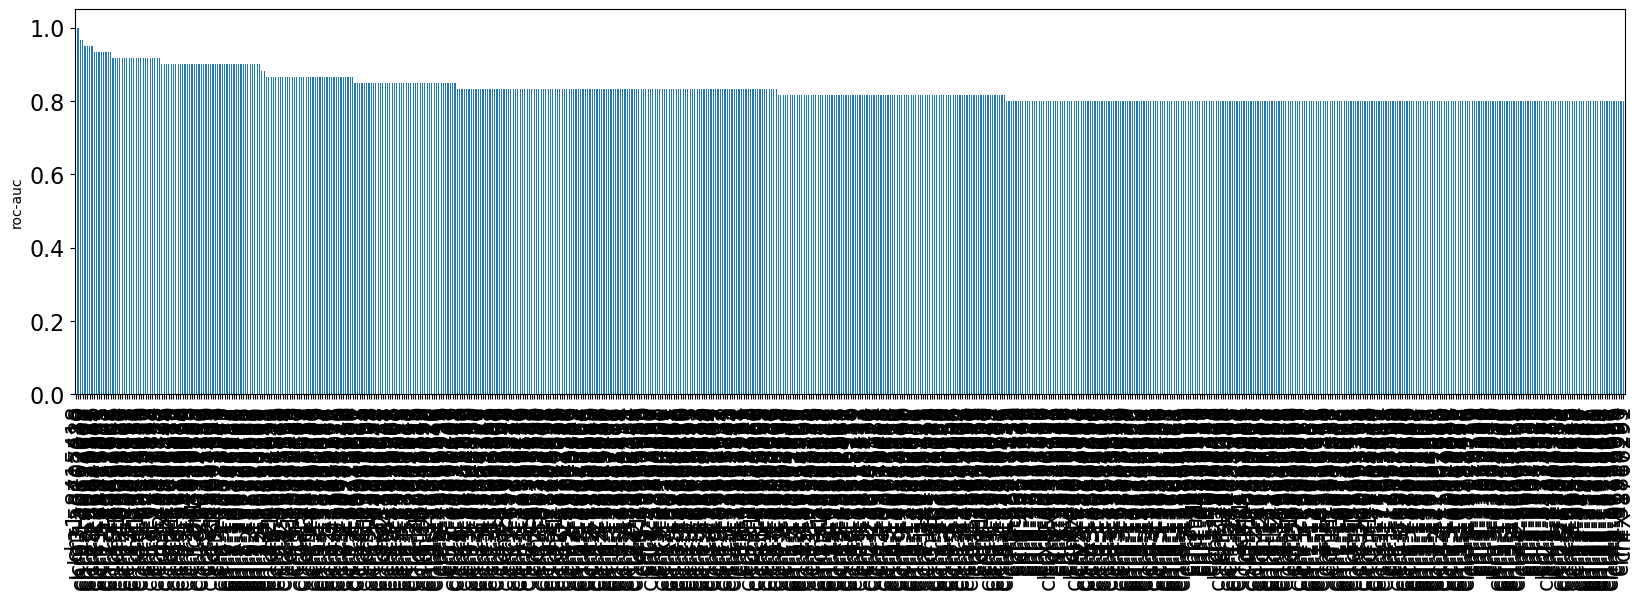

In [32]:
# now let's:

# 1) capture the roc-auc values in a pandas series
# 2) add the variable names in the index
# 3) sort the features based on the roc-auc
# 4) and make a var plot

roc_values = pd.Series(roc_values)
roc_values.index = X_train_Dup.columns
roc_values[roc_values >= 0.8].sort_values(ascending=False).plot.bar(figsize=(20, 5), fontsize = 16)
plt.ylabel('roc-auc')

In [33]:
# a roc auc value of 0.8 indicates confident decision of 80% 
# let's check how many features show a roc-auc value
# higher than or equal to 0.8
roc_values = pd.Series(roc_values)
roc_values.index = X_train_Dup.columns
len(roc_values[roc_values >= 0.8])

666

In [34]:
#Select features with roc-auc >= 0.8
selected_features_DT = roc_values[roc_values >= 0.8].index

print(selected_features_DT)

Index(['chr1-100342227', 'chr1-100343073', 'chr1-100345409', 'chr1-100358103',
       'chr1-100376448', 'chr1-108734993', 'chr1-109349879', 'chr1-109726695',
       'chr1-109796053', 'chr1-110210818',
       ...
       'chrX-40573774', 'chrX-44494967', 'chrX-45060191', 'chrX-47065186',
       'chrX-53652838', 'chrX-53652844', 'chrX-55248376', 'chrX-55249049',
       'chrX-68393892', 'chrX-8766291'],
      dtype='object', length=666)


In [35]:
# select features in the dataframes

X_train_univariate_DT = X_train_Dup[selected_features_DT]
X_test_univariate_DT = X_test_Dup[selected_features_DT]

#print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_univariate_DT.shape, X_test_univariate_DT.shape)
print(y_train.shape, y_test.shape)

(30, 63089) (11, 63089)
(30, 666) (11, 666)
(30, 1) (11, 1)


> # Correlation Feature Selection
#### Finding correlations between features that resulted after selction using single ML algorithm for each feature

### Identify groups of highly correlated features

Now we looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [36]:
%%time
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train_univariate_DT.corr(method= 'spearman')
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.7]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
print(corrmat.shape)
corrmat.head()


(1462, 3)
CPU times: user 100 ms, sys: 11.4 ms, total: 112 ms
Wall time: 115 ms


,feature1,feature2,corr
0,chr22-18717939,chr9-115983540,0.998082
1,chr9-115983540,chr22-18717939,0.998082
2,chr1-207749188,chr1-207726000,0.997344
3,chr1-207726000,chr1-207749188,0.997344
4,chr3-38047680,chr3-38050159,0.996546


In [37]:
len(corrmat['feature1'].unique())

495

In [38]:
### Here we want to find features that are un-correlated OR has a correlation coefficient less than 0.7

uncorr_predictors = []
for col in X_train_univariate_DT.columns:
    if col not in corrmat['feature1'].unique():
        uncorr_predictors.append(col)
print(len(uncorr_predictors))        

171


In [39]:
correlated_block = corrmat[corrmat.feature1 == 'chr3-38047680']
correlated_block 

,feature1,feature2,corr
4,chr3-38047680,chr3-38050159,0.996546
679,chr3-38047680,chr3-38047211,0.754330


In [40]:
grouped_feature_ls = list(correlated_block.feature2.unique()) + ['chr3-38047680']
len(grouped_feature_ls)

3

In [41]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in tqdm(corrmat.feature1.unique()):
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train_univariate_DT.shape[1]))

  0%|          | 0/495 [00:00<?, ?it/s]

found 213 correlated groups
out of 666 total features


In [42]:
len (correlated_groups)

213

* Now we can build a machine learning algorithm for every correlated group, and select the most predictive feature and discard the rest within that correlated group
.

In [43]:
%%time

most_important_features = []
for group in tqdm(correlated_groups):
    # add all features of that specific group to a list
    features_in_group = list(group['feature2'].unique())
    features_in_group.extend(group['feature1'].unique())
    print('there are {} correlated featureas '.format(len(features_in_group)))
    # train a random forest 
    rf = RandomForestClassifier(n_estimators=100, random_state=2023, max_depth=4)
    rf.fit(X_train_univariate_DT[features_in_group], np.ravel(y_train))
    # get the feature importance attributed by the random forest model

    importance = pd.concat([pd.Series(features_in_group),pd.Series(rf.feature_importances_)], axis=1)
    importance.columns = ['feature', 'importance']

    # sort features by importance, most important first
    importance.sort_values(by='importance', ascending=False)
    if importance['feature'][0] not in most_important_features:
        most_important_features.append(importance['feature'][0])
print (len(most_important_features))

  0%|          | 0/213 [00:00<?, ?it/s]

there are 2 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 6 correlated featureas 
there are 3 correlated featureas 
there are 11 correlated featureas 
there are 8 correlated featureas 
there are 6 correlated featureas 
there are 10 correlated featureas 
there are 7 correlated featureas 
there are 8 correlated featureas 
there are 3 correlated featureas 
there are 9 correlated featureas 
there are 5 correlated featureas 
there are 8 correlated featureas 
there are 3 correlated featureas 
there are 4 correlated featureas 
there are 6 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 4 correlated featureas 
there are 5 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 6 correlated featureas 
there are 2 correlated featureas 
there are 3 correlated featureas 
there are 3 correlated featureas 
there are 3 

In [44]:
len(most_important_features)

178

In [45]:
final_selected_feat = most_important_features + uncorr_predictors
print(len(most_important_features))
print(len(uncorr_predictors))
print(len(final_selected_feat))

178
171
349


In [46]:
# select features in the dataframes

X_train_uncorr = X_train_univariate_DT[final_selected_feat]
X_test_uncorr = X_test_univariate_DT[final_selected_feat]

#print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_univariate_DT.shape, X_test_univariate_DT.shape)
print(X_train_uncorr.shape, X_test_uncorr.shape)
print(y_train.shape, y_test.shape)

(30, 63089) (11, 63089)
(30, 666) (11, 666)
(30, 349) (11, 349)
(30, 1) (11, 1)


# Trial Classifiers

In [47]:
classifiers = [DecisionTreeClassifier(max_depth=3, random_state=2023),
               RandomForestClassifier(n_estimators=100, max_features=3, max_depth=3, random_state=2023),
               KNeighborsClassifier(n_neighbors=5),
               SVC(random_state=781),
               LogisticRegression(random_state=2023),
               GradientBoostingClassifier(),
               AdaBoostClassifier(),
               xgb.XGBClassifier(learning_rate=2)]
Names = ['DecitionTree', 'Random Forest', 'KNN', 'SVM', 'Logistic', 'GBoost', 'AdaBoost', 'XGBClassifier']
scoring = {'acc' : make_scorer(accuracy_score),
           'f1' : make_scorer(f1_score), 
           'roc_auc' : make_scorer(roc_auc_score),
           'PR_auc' : make_scorer(average_precision_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score)}
Models = zip(Names, classifiers)
              
# Evaluate different models:


Results = []
Names = []

for name , model in Models:
    model_fit = model.fit(X_train_uncorr, np.ravel(y_train))
    Y_train_pred_model = model_fit.predict(X_train_uncorr)
    Y_test_pred_model = model_fit.predict(X_test_uncorr)
    _results1 = model_fit.score(X_train_uncorr, y_train)
    _results = model_fit.score(X_test_uncorr, y_test)
    Results.append(_results)
    Names.append(name)
    print (name , 'test accuracy: ', str(_results))
    print(classification_report(y_test, Y_test_pred_model)) 
    

DecitionTree test accuracy:  0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      1.00      0.86         6

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11

Random Forest test accuracy:  0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

KNN test accuracy:  0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91   

In [48]:
print(Names)
print(Results)

['DecitionTree', 'Random Forest', 'KNN', 'SVM', 'Logistic', 'GBoost', 'AdaBoost', 'XGBClassifier']
[0.8181818181818182, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091]


In [49]:
classifiers = [DecisionTreeClassifier(max_depth=3, random_state=2023),
               RandomForestClassifier(n_estimators=100, max_features=3, max_depth=3, random_state=2023),
               KNeighborsClassifier(n_neighbors=5),
               SVC(random_state=78),
               LogisticRegression(random_state=2023),
               GradientBoostingClassifier(),
               AdaBoostClassifier(),
               xgb.XGBClassifier(learning_rate=2)]
Names = ['DecitionTree', 'Random Forest', 'KNN', 'SVM', 'Logistic', 'GBoost', 'AdaBoost', 'XGBClassifier']
scoring = {'acc' : make_scorer(accuracy_score),
           'f1' : make_scorer(f1_score), 
           'roc_auc' : make_scorer(roc_auc_score),
           'PR_auc' : make_scorer(average_precision_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score)}
Models = zip(Names, classifiers)

# loop through the models and fit all X, y and evaluate the model using 5 kfold cross validation
# and store each type of score range in a list then store total scores for each model in a dictionary
#score = {}
results = {}
cv = KFold(n_splits=5, shuffle=True,random_state=2023 )
for name , model in Models:
    score = cross_validate(model, X_train_uncorr, np.ravel(y_train), return_train_score=True, scoring = scoring, cv = 5)
    results[name] = score

In [50]:
score

{'fit_time': array([0.11123776, 0.12165642, 0.10696554, 0.10891366, 0.1009481 ]),
 'score_time': array([0.00987649, 0.01082492, 0.01068425, 0.0104413 , 0.01066446]),
 'test_acc': array([0.83333333, 0.33333333, 0.5       , 0.33333333, 0.5       ]),
 'train_acc': array([0.91666667, 0.91666667, 0.875     , 0.91666667, 0.91666667]),
 'test_f1': array([0.88888889, 0.33333333, 0.66666667, 0.5       , 0.4       ]),
 'train_f1': array([0.92307692, 0.92307692, 0.88888889, 0.92857143, 0.92307692]),
 'test_roc_auc': array([0.75      , 0.33333333, 0.5       , 0.33333333, 0.5       ]),
 'train_roc_auc': array([0.91666667, 0.91608392, 0.87062937, 0.90909091, 0.91608392]),
 'test_PR_auc': array([0.8       , 0.44444444, 0.5       , 0.43333333, 0.5       ]),
 'train_PR_auc': array([0.85714286, 0.89373767, 0.83287546, 0.86666667, 0.89373767]),
 'test_Recall': array([1.        , 0.33333333, 1.        , 0.66666667, 0.33333333]),
 'train_Recall': array([1.        , 0.92307692, 0.92307692, 1.        , 0.923

In [51]:
pd.DataFrame(results)

,DecitionTree,Random Forest,KNN,SVM,Logistic,GBoost,AdaBoost,XGBClassifier
fit_time,"[0.004395246505737305, 0.003168821334838867, 0...","[0.10113859176635742, 0.10430550575256348, 0.0...","[0.002672433853149414, 0.002637624740600586, 0...","[0.003239870071411133, 0.002721071243286133, 0...","[0.009208440780639648, 0.006113529205322266, 0...","[0.06878399848937988, 0.050862789154052734, 0....","[0.0503079891204834, 0.050126075744628906, 0.0...","[0.11123776435852051, 0.12165641784667969, 0.1..."
score_time,"[0.005290985107421875, 0.005021810531616211, 0...","[0.011806726455688477, 0.011096954345703125, 0...","[0.005605459213256836, 0.005388736724853516, 0...","[0.0047550201416015625, 0.004669666290283203, ...","[0.005223512649536133, 0.004520893096923828, 0...","[0.004876852035522461, 0.004786252975463867, 0...","[0.009876728057861328, 0.009719610214233398, 0...","[0.009876489639282227, 0.010824918746948242, 0..."
test_acc,"[0.5, 0.3333333333333333, 0.3333333333333333, ...","[0.6666666666666666, 0.6666666666666666, 0.5, ...","[0.6666666666666666, 0.16666666666666666, 0.5,...","[0.6666666666666666, 0.16666666666666666, 0.5,...","[0.6666666666666666, 0.3333333333333333, 0.5, ...","[0.5, 0.3333333333333333, 0.5, 0.5, 0.83333333...","[0.3333333333333333, 0.5, 0.6666666666666666, ...","[0.8333333333333334, 0.3333333333333333, 0.5, ..."
train_acc,"[0.875, 1.0, 0.9166666666666666, 0.91666666666...","[0.9166666666666666, 1.0, 0.9166666666666666, ...","[0.7916666666666666, 0.6666666666666666, 0.583...","[0.9166666666666666, 1.0, 0.9166666666666666, ...","[0.9166666666666666, 1.0, 0.9166666666666666, ...","[0.9583333333333334, 1.0, 0.9166666666666666, ...","[0.9583333333333334, 1.0, 0.9166666666666666, ...","[0.9166666666666666, 0.9166666666666666, 0.875..."
test_f1,"[0.4, 0.3333333333333333, 0.3333333333333333, ...","[0.8, 0.7499999999999999, 0.6666666666666666, ...","[0.8, 0.28571428571428575, 0.6666666666666666,...","[0.8, 0.0, 0.6666666666666666, 0.6666666666666...","[0.8, 0.3333333333333333, 0.5714285714285715, ...","[0.5714285714285715, 0.3333333333333333, 0.666...","[0.5, 0.6666666666666666, 0.7499999999999999, ...","[0.888888888888889, 0.3333333333333333, 0.6666..."
train_f1,"[0.8571428571428571, 1.0, 0.9285714285714286, ...","[0.923076923076923, 1.0, 0.9285714285714286, 0...","[0.8148148148148148, 0.7647058823529412, 0.722...","[0.923076923076923, 1.0, 0.9285714285714286, 0...","[0.923076923076923, 1.0, 0.9285714285714286, 0...","[0.9600000000000001, 1.0, 0.9285714285714286, ...","[0.9600000000000001, 1.0, 0.9285714285714286, ...","[0.923076923076923, 0.9230769230769231, 0.8888..."
test_roc_auc,"[0.625, 0.33333333333333337, 0.333333333333333...","[0.5, 0.6666666666666667, 0.5, 0.6666666666666...","[0.5, 0.16666666666666666, 0.5, 0.5, 0.5]","[0.5, 0.16666666666666669, 0.5, 0.5, 0.5]","[0.5, 0.33333333333333337, 0.5, 0.5, 0.6666666...","[0.5, 0.33333333333333337, 0.5, 0.5, 0.8333333...","[0.25, 0.5, 0.6666666666666667, 0.666666666666...","[0.75, 0.33333333333333337, 0.5, 0.33333333333..."
train_roc_auc,"[0.875, 1.0, 0.9090909090909091, 0.90909090909...","[0.9166666666666667, 1.0, 0.9090909090909091, ...","[0.7916666666666667, 0.6363636363636364, 0.545...","[0.9166666666666667, 1.0, 0.9090909090909091, ...","[0.9166666666666667, 1.0, 0.9090909090909091, ...","[0.9583333333333333, 1.0, 0.9090909090909091, ...","[0.9583333333333333, 1.0, 0.9090909090909091, ...","[0.9166666666666667, 0.9160839160839161, 0.870..."
test_PR_auc,"[0.75, 0.4444444444444445, 0.4444444444444445,...","[0.6666666666666666, 0.6, 0.5, 0.6, 0.75]","[0.6666666666666666, 0.4166666666666667, 0.5, ...","[0.6666666666666666, 0.5, 0.5, 0.5, 0.5]","[0.6666666666666666, 0.4444444444444445, 0.5, ...","[0.6666666666666666, 0.4444444444444445, 0.5, ...","[0.5833333333333333, 0.5, 0.6, 0.6666666666666...","[0.8, 0.4444444444444445, 0.5, 0.4333333333333..."
train_PR_auc,"[0.875, 1.0, 0.8666666666666667, 0.86666666666...","[0.8571428571428571, 1.0, 0.8666666666666667, ...","[

In [52]:
# loop through result dictionary and store the mean for each score for all three models
for model, test in results.items():
    for (k1,v1)in test.items():
        if 'time' in k1:
            test[k1] = round(v1.max(), 2)
        else:
            test[k1] = round(v1.mean(), 2)

In [53]:
pd.DataFrame(results)

,DecitionTree,Random Forest,KNN,SVM,Logistic,GBoost,AdaBoost,XGBClassifier
fit_time,0.01,0.10,0.00,0.01,0.01,0.07,0.06,0.12
score_time,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01
test_acc,0.43,0.67,0.47,0.47,0.53,0.53,0.57,0.50
train_acc,0.92,0.93,0.68,0.93,0.93,0.94,0.94,0.91
test_f1,0.45,0.76,0.62,0.56,0.61,0.62,0.62,0.56
train_f1,0.93,0.94,0.77,0.94,0.94,0.95,0.95,0.92
test_roc_auc,0.46,0.63,0.43,0.43,0.50,0.53,0.55,0.48
train_roc_auc,0.92,0.93,0.65,0.93,0.93,0.94,0.94,0.91
test_PR_auc,0.54,0.62,0.52,0.53,0.54,0.57,0.59,0.54
train_PR_auc,0.89,0.89,0.63,0.89,0.89,0.90,0.92,0.87


# Train First Model 
> # KNN Classifier

In [ ]:
## Try a raw KNN classifier without any hyperparameter tunning on all feature subsets after removing constant, quasi-costant
# and duplicate features & uncorrelated features: 

def run_KNN(X_train, X_test, y_train, y_test):
    KNN_clf1 =  KNeighborsClassifier()
    KNN_fit = KNN_clf1.fit (X_train, np.ravel(y_train))
    Y_train_pred_KNN_clf1 = KNN_fit.predict(X_train)
    Y_test_pred_KNN_clf1 = KNN_fit.predict(X_test)
  
    ## Evaluating the Model 
    print (f'Accuracy-score of KNN raw model on train data: {round(accuracy_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'Accuracy-score of KNN raw model on test data: {round(accuracy_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print()
    print (f'ROC-AUC-score of KNN raw model on train data: {round(roc_auc_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'ROC-AUC-score of KNN raw model on test data: {round(roc_auc_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print() 
    print (f'F1-score of KNN raw model on train data: {round(f1_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'F1-score of KNN raw model on test data: {round(f1_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print()
    print (f'Recall_score of KNN raw model on train data: {round(recall_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'Recall_score of KNN raw model on test data: {round(recall_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print()
    print (f'Percision_score of KNN raw model on train data: {round(precision_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'Percision_score of KNN raw model on test data: {round(precision_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print()
    print (f'PR_AUC of KNN raw model on train data: {round(average_precision_score(y_train,Y_train_pred_KNN_clf1),3)}')
    print (f'PR_AUC of KNN raw model on test data: {round(average_precision_score(y_test,Y_test_pred_KNN_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_KNN_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_KNN_clf1),3)
    print(f'False Negative Rate of DT raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of DT raw model on test data: {round(FPR,3)}')


In [ ]:
run_KNN(X_train_Dup, X_test_Dup, y_train, y_test)

In [ ]:
run_KNN(X_train_uncorr, X_test_uncorr, y_train, y_test)

In [ ]:
run_KNN(X_train_Embedded, X_test_Embedded, y_train, y_test)

> # Grid Search for DT Hyperparameter tunning on uncorrelated dataset

In [ ]:
%%time
# Create the parameter grid
KNN_param = { 'n_neighbors': [3, 5, ,7, 10],
             'weights' : ['uniform', 'distance'],
         'metric' : ['euclidean', 'manhattan', 'minkowski', 'cosine'],
         'leaf_size': range(1,25,5)
}

# First create the base model to tune
KNN = KNeighborsClassifier(random_state=2023)

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of DT model by using 25 splits and use PR AUC score for scoring
KNN_GridSearch0 = GridSearchCV(estimator=KNN, 
                           param_grid= KNN_param, 
                           cv=cv, n_jobs=-1, verbose=1, return_train_score=True, scoring = make_scorer(roc_auc_score))


# fit the DT model using each combination of parameters created by gridsearch
KNN_GridSearch0.fit(X_train_uncorr, y_train) 

# get the best parameters
print(f'DT best parameters:  {KNN_GridSearch0.best_params_}')
print(f'DT best ROC_AUC: {round(KNN_GridSearch0.best_score_, 3)}' )

# Train Second Model
> # Decision Tree Classifier

> # Create a raw DT classifier and Compare its performance on different feature subsets:

In [30]:
## Try a raw DT classifier without any hyperparameter tunning on all feature subsets after removing constant, quasi-costant
# and duplicate features & uncorrelated features: 

def run_DecisionTree(X_train, X_test, y_train, y_test):
    DT_clf1 =  DecisionTreeClassifier(random_state=87)
    DT_clf1_fit = DT_clf1.fit (X_train, y_train)
    Y_train_pred_DT_clf1 = DT_clf1_fit.predict(X_train)
    Y_test_pred_DT_clf1 = DT_clf1_fit.predict(X_test)
  
    ## Evaluating the Model 
    print (f'Accuracy-score of DT raw model on train data: {round(accuracy_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Accuracy-score of DT raw model on test data: {round(accuracy_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'ROC-AUC-score of DT raw model on train data: {round(roc_auc_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'ROC-AUC-score of DT raw model on test data: {round(roc_auc_score(y_test,Y_test_pred_DT_clf1),3)}')
    print() 
    print (f'F1-score of DT raw model on train data: {round(f1_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'F1-score of DT raw model on test data: {round(f1_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'Recall_score of DT raw model on train data: {round(recall_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Recall_score of DT raw model on test data: {round(recall_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'Percision_score of DT raw model on train data: {round(precision_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Percision_score of DT raw model on test data: {round(precision_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'PR_AUC of DT raw model on train data: {round(average_precision_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'PR_AUC of DT raw model on test data: {round(average_precision_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_DT_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_DT_clf1),3)
    print(f'False Negative Rate of DT raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of DT raw model on test data: {round(FPR,3)}')


In [ ]:
run_DecisionTree(X_train_Dup, X_test_Dup, y_train, y_test)

In [31]:
run_DecisionTree(X_train_uncorr, X_test_uncorr, y_train, y_test)

Accuracy-score of DT raw model on train data: 0.933
Accuracy-score of DT raw model on test data: 0.909

ROC-AUC-score of DT raw model on train data: 0.929
ROC-AUC-score of DT raw model on test data: 0.9

F1-score of DT raw model on train data: 0.941
F1-score of DT raw model on test data: 0.923

Recall_score of DT raw model on train data: 1.0
Recall_score of DT raw model on test data: 1.0

Percision_score of DT raw model on train data: 0.889
Percision_score of DT raw model on test data: 0.857

PR_AUC of DT raw model on train data: 0.889
PR_AUC of DT raw model on test data: 0.857

False Negative Rate of DT raw model on test data: 0.0
False Positive Rate of DT raw model on test data: 0.2


In [ ]:
run_DecisionTree(X_train_Embedded, X_test_Embedded, y_train, y_test)

> # Grid Search for DT Hyperparameter tunning on uncorrelated dataset

In [32]:
%%time
# Create the parameter grid
dt_param = { 'max_depth': [2, 3, 5, 10],
         'min_samples_leaf': [3 ,4, 5,10,15,20],
         'min_samples_split': [2,6,10,14,18,22],
         'criterion': ["gini", "entropy"]
}

# First create the base model to tune
dt = DecisionTreeClassifier(random_state=2023)

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of DT model by using 25 splits and use PR AUC score for scoring
Decision_Tree_GridSearch = GridSearchCV(estimator=dt, 
                           param_grid= dt_param, 
                           cv=cv, n_jobs=-1, verbose=1, return_train_score=True, scoring = make_scorer(roc_auc_score))


# fit the DT model using each combination of parameters created by gridsearch
Decision_Tree_GridSearch.fit(X_train_uncorr, y_train) 

# get the best parameters
print(f'DT best parameters:  {Decision_Tree_GridSearch.best_params_}')
print(f'DT best ROC_AUC: {round(Decision_Tree_GridSearch.best_score_, 3)}' )

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
DT best parameters:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 22}
DT best ROC_AUC: 0.533
CPU times: user 789 ms, sys: 331 ms, total: 1.12 s
Wall time: 6.67 s


In [58]:
Decision_Tree_GridSearch.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 22}

In [34]:
Decision_Tree_GridSearch_results = pd.DataFrame(Decision_Tree_GridSearch.cv_results_)

In [35]:
Decision_Tree_GridSearch_results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010145,0.000765,0.008210,0.001225,gini,2,3,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.5,...,0.5,0.149071,61,0.833333,0.77972,0.77972,0.916084,0.870629,0.835897,0.052829
1,0.009408,0.000973,0.007365,0.000707,gini,2,3,6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.5,...,0.5,0.149071,61,0.833333,0.77972,0.77972,0.916084,0.870629,0.835897,0.052829
2,0.007328,0.000436,0.006392,0.000336,gini,2,3,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.5,...,0.5,0.149071,61,0.833333,0.77972,0.77972,0.916084,0.870629,0.835897,0.052829
3,0.007517,0.000203,0.006738,0.000523,gini,2,3,14,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.5,...,0.5,0.149071,61,0.833333,0.77972,0.77972,0.916084,0.870629,0.835897,0.052829
4,0.006972,0.000201,0.006126,0.000201,gini,2,3,18,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.5,...,0.5,0.149071,61,0.791667,0.77972,0.77972,0.916084,0.870629,0.827564,0.055780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.006078,0.000154,0.006096,0.000312,entropy,10,20,6,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.5,...,0.5,0.000000,61,0.500000,0.50000,0.50000,0.500000,0.500000,0.500000,0.000000
284,0.005006,0.001447,0.004760,0.001360,entropy,10,20,10,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.5,...,0.5,0.000000,61,0.500000,0.50000,0.50000,0.500000,0.500000,0.500000,0.000000
285,0.006586,0.000513,0.005980,0.000327,entropy,10,20,14,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.5,...,0.5,0.000000,61,0.500000,0.50000,0.50000,0.500000,0.500000,0.500000,0.000000
286,0.006433,0.000253,0.006122,0.000200,entropy,10,20,18,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.5,...,0.5,0.000000,61,0.500000,0.50000,0.50000,0.500000,0.500000,0.500000,0.000000


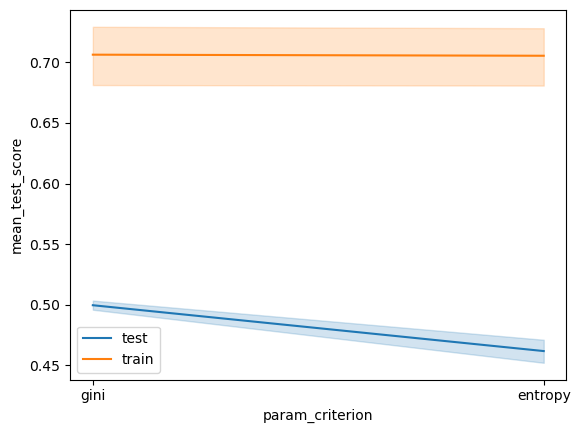

In [43]:
## Draw Train error versus test error 
sns.lineplot(x= Decision_Tree_GridSearch_results['param_criterion'],y= Decision_Tree_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= Decision_Tree_GridSearch_results['param_criterion'],y= Decision_Tree_GridSearch_results['mean_train_score'],label = 'train')
#plt.ylim([0,1.0])
plt.legend()
plt.show()

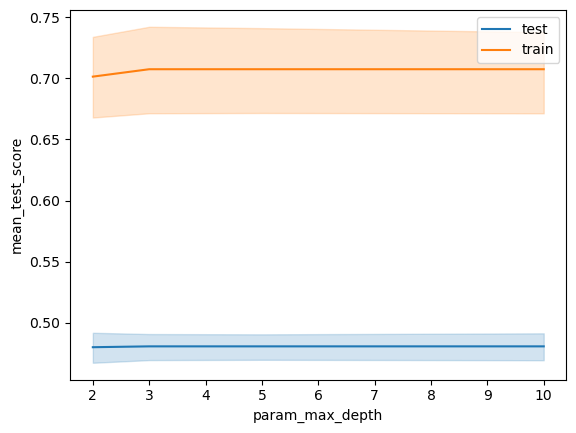

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= Decision_Tree_GridSearch_results['param_max_depth'],y= Decision_Tree_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= Decision_Tree_GridSearch_results['param_max_depth'],y= Decision_Tree_GridSearch_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= Decision_Tree_GridSearch_results['param_min_samples_leaf'],y= Decision_Tree_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= Decision_Tree_GridSearch_results['param_min_samples_leaf'],y= Decision_Tree_GridSearch_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= Decision_Tree_GridSearch_results['param_min_samples_split'],y= Decision_Tree_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= Decision_Tree_GridSearch_results['param_min_samples_split'],y= Decision_Tree_GridSearch_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

> ## Test the generalizability of the DT GridSAearch Best parameters model

In [50]:
%%time
# 
Dtree = DecisionTreeClassifier(random_state=2023, **Decision_Tree_GridSearch.best_params_)

# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

scoring = {'acc' : make_scorer(accuracy_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'f1' : make_scorer(f1_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'PR_auc' : make_scorer(average_precision_score),}

# estimate generalization error
DtreeCV =  cross_validate(
    Dtree,
    X_train_uncorr, 
    np.ravel(y_train),
    scoring= scoring,
    return_train_score=True,
    cv=kf # k-fold
)

print('mean train set accuracy: ', np.mean(DtreeCV['train_acc']), ' +- ', np.std(DtreeCV['train_acc']))
print('mean test set accuracy: ', np.mean(DtreeCV['test_acc']), ' +- ', np.std(DtreeCV['test_acc']))
print('=========================================================')
print('mean train set roc_auc: ', np.mean(DtreeCV['train_roc_auc']), ' +- ', np.std(DtreeCV['train_roc_auc']))
print('mean test set roc_auc: ', np.mean(DtreeCV['test_roc_auc']), ' +- ', np.std(DtreeCV['test_roc_auc']))
print('=========================================================')
print('mean train set f1: ', np.mean(DtreeCV['train_f1']), ' +- ', np.std(DtreeCV['train_f1']))
print('mean test set f1: ', np.mean(DtreeCV['test_f1']), ' +- ', np.std(DtreeCV['test_f1']))
print('=========================================================')
print('mean train set Recall: ', np.mean(DtreeCV['train_Recall']), ' +- ', np.std(DtreeCV['train_Recall']))
print('mean test set Recall: ', np.mean(DtreeCV['test_Recall']), ' +- ', np.std(DtreeCV['test_Recall']))
print('=========================================================')
print('mean train set Precision: ', np.mean(DtreeCV['train_Precision']), ' +- ', np.std(DtreeCV['train_Precision']))
print('mean test set Precision: ', np.mean(DtreeCV['test_Precision']), ' +- ', np.std(DtreeCV['test_Precision']))
print('=========================================================')
print('mean train set PR_auc: ', np.mean(DtreeCV['train_PR_auc']), ' +- ', np.std(DtreeCV['train_PR_auc']))
print('mean test set PR_auc: ', np.mean(DtreeCV['test_PR_auc']), ' +- ', np.std(DtreeCV['test_PR_auc']))



NameError: name 'Decision_Tree_GridSearch' is not defined

In [55]:
pd.DataFrame(DtreeCV)

,fit_time,score_time,test_acc,train_acc,test_roc_auc,train_roc_auc,test_f1,train_f1,test_Recall,train_Recall,test_Precision,train_Precision,test_PR_auc,train_PR_auc
0,0.006685,0.005849,0.333333,0.791667,0.375000,0.791667,0.333333,0.761905,0.250000,0.666667,0.500000,0.888889,0.625000,0.759259
1,0.004195,0.005550,0.500000,0.791667,0.500000,0.779720,0.666667,0.827586,1.000000,0.923077,0.500000,0.750000,0.500000,0.733974
2,0.003182,0.005006,0.333333,0.791667,0.333333,0.772727,0.333333,0.838710,0.333333,1.000000,0.333333,0.722222,0.444444,0.722222
3,0.005317,0.005052,0.666667,0.791667,0.666667,0.779720,0.750000,0.827586,1.000000,0.923077,0.600000,0.750000,0.600000,0.733974
4,0.003011,0.004894,0.500000,0.833333,0.500000,0.818182,0.571429,0.866667,0.666667,1.000000,0.500000,0.764706,0.500000,0.764706


> #  External Tesing:

In [56]:
## Try a DT classifier AFTER hyperparameter tunning on all feature subsets after removing constant, quasi-costant, duplicate features, RFE and univariate DT feature selection: 


def run_Tuned_DecisionTree(X_train, X_test, y_train, y_test):
    DT_clf1 = DecisionTreeClassifier(random_state=87, **Decision_Tree_GridSearch.best_params_)
    DT_clf1_fit = DT_clf1.fit (X_train, y_train)
    Y_train_pred_DT_clf1 = DT_clf1_fit.predict(X_train)
    Y_test_pred_DT_clf1 = DT_clf1_fit.predict(X_test)
    
    ## Evaluating the Model 
    print (f'Accuracy-score of DT tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Accuracy-score of DT tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'ROC-AUC-score of DT tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'ROC-AUC-score of DT tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_DT_clf1),3)}')
    print() 
    print (f'F1-score of DT tunned model on train data: {round(f1_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'F1-score of DT tunned model on test data: {round(f1_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'Recall_score of DT tunned model on train data: {round(recall_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Recall_score of DT tunned model on test data: {round(recall_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'Percision_score of DT tunned model on train data: {round(precision_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'Percision_score of DT tunned model on test data: {round(precision_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()
    print (f'PR_AUC of DT tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_DT_clf1),3)}')
    print (f'PR_AUC of DT tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_DT_clf1),3)}')
    print()

    CM = confusion_matrix(y_test,Y_test_pred_DT_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_DT_clf1),3)
    print(f'False Negative Rate of DT tunned model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of DT tunned model on test data: {round(FPR,3)}')


> ## Test DT performance on uncorrelated features ** After Tunning**:

In [57]:
run_Tuned_DecisionTree(X_train_uncorr, X_test_uncorr, y_train, y_test)

Accuracy-score of DT tunned model on train data: 0.767
Accuracy-score of DT tunned model on test data: 0.818

ROC-AUC-score of DT tunned model on train data: 0.754
ROC-AUC-score of DT tunned model on test data: 0.8

F1-score of DT tunned model on train data: 0.811
F1-score of DT tunned model on test data: 0.857

Recall_score of DT tunned model on train data: 0.938
Recall_score of DT tunned model on test data: 1.0

Percision_score of DT tunned model on train data: 0.714
Percision_score of DT tunned model on test data: 0.75

PR_AUC of DT tunned model on train data: 0.703
PR_AUC of DT tunned model on test data: 0.75

False Negative Rate of DT tunned model on test data: 0.0
False Positive Rate of DT tunned model on test data: 0.4


In [ ]:
from sklearn import tree
from IPython.display import Image
import pydotplus

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2 ,min_samples_leaf=3, min_samples_split=2, random_state=87)
dt_fit = dt.fit(X_train_RFE, y_train)

dot_data = tree.export_graphviz(dt, out_file=None,feature_names= X_train_RFE.columns, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Train Third model
> # RandomForest Classifier

> ## Create a raw RF classifier and Compare its performance on different feature subsets:

In [ ]:
## Try a raw RF classifier without any hyperparameter tunning on all features subsets after removing constant, quasi-costant and duplicate features and RFE: 
# Without any further feature selection check auuracy with Random forest

def run_RandomForest(X_train, X_test, y_train, y_test):
    rf_clf1 = RandomForestClassifier(random_state=42)
    rf_clf1_fit = rf_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_rf_clf1 = rf_clf1_fit.predict(X_train)
    Y_test_pred_rf_clf1 = rf_clf1_fit.predict(X_test)
    
    ## Evaluating the Model 
    print (f'Accuracy-score of RF raw model on train data: {round(accuracy_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Accuracy-score of RF raw model on test data: {round(accuracy_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'ROC-AUC-score of RF raw model on train data: {round(roc_auc_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'ROC-AUC-score of RF raw model on test data: {round(roc_auc_score(y_test,Y_test_pred_rf_clf1),3)}')
    print() 
    print (f'F1-score of RF raw model on train data: {round(f1_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'F1-score of RF raw model on test data: {round(f1_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'Recall_score of RF raw model on train data: {round(recall_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Recall_score of RF raw model on test data: {round(recall_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'Percision_score of RF raw model on train data: {round(precision_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Percision_score of RF raw model on test data: {round(precision_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'PR_AUC of RF raw model on train data: {round(average_precision_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'PR_AUC of RF raw model on test data: {round(average_precision_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_rf_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_rf_clf1),3)
    print(f'False Negative Rate of RF raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF raw model on test data: {round(FPR,3)}')


> # Compare RF performance for different features selected:

In [ ]:
run_RandomForest(X_train_QC, X_test_QC, y_train, y_test)

In [ ]:
run_RandomForest(X_train_Dup, X_test_Dup, y_train, y_test)

In [ ]:
run_RandomForest(X_train_Embedded, X_test_Embedded, y_train, y_test)

> # Grid Search for RF Hyperparameter tunning on RFE dataset

In [ ]:
%%time
# Create the parameter grid
param_RF = { 'n_estimators': [50, 100, 200, 300,400],
        'max_depth': [2, 3, 5],
         'min_samples_leaf': [3,5,7,9],
         'min_samples_split': [2,4,8,12,16, 18],
            'criterion': ['gini', 'entropy']
         }

# First create the base model to tune
RF = RandomForestClassifier(random_state=42)

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= KFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of DT model by using 25 splits and use PR AUC score for scoring
RF_GridSearch1 = GridSearchCV(estimator=RF, 
                           param_grid=param_RF, 
                           cv=cv, n_jobs=-1,return_train_score=True ,scoring = make_scorer(roc_auc_score), verbose= 1)

# fit the DT model using each combination of parameters created by gridsearch
RF_GridSearch1.fit(X_train_Embedded, np.ravel(y_train)) 

# get the best parameters
RF_GridSearch1.best_params_

In [ ]:
RF_GridSearch1_results = pd.DataFrame(RF_GridSearch1.cv_results_)
RF_GridSearch1_results.columns

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= RF_GridSearch1_results['param_criterion'],y= RF_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= RF_GridSearch1_results['param_criterion'],y= RF_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= RF_GridSearch1_results['param_n_estimators'],y= RF_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= RF_GridSearch1_results['param_n_estimators'],y= RF_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= RF_GridSearch1_results['param_max_depth'],y= RF_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= RF_GridSearch1_results['param_max_depth'],y= RF_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= RF_GridSearch1_results['param_min_samples_leaf'],y= RF_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= RF_GridSearch1_results['param_min_samples_leaf'],y= RF_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= RF_GridSearch1_results['param_min_samples_split'],y= RF_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= RF_GridSearch1_results['param_min_samples_split'],y= RF_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

> ## Test the generalizability of the RF GridSearch Best parameters model

In [ ]:
%%time
# 
rf_clf2 = RandomForestClassifier(random_state=87,**RF_GridSearch1.best_params_)

# K-Fold Cross-Validation
kf = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state=4)

scoring = {'acc' : make_scorer(accuracy_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'f1' : make_scorer(f1_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'PR_auc' : make_scorer(average_precision_score),}

# estimate generalization error
RF_CV =  cross_validate(
    rf_clf2,
    X_train_Embedded, 
    np.ravel(y_train),
    scoring= scoring,
    return_train_score=True,
    cv=kf # k-fold
)

print('mean train set accuracy: ', np.mean(RF_CV['train_acc']), ' +- ', np.std(RF_CV['train_acc']))
print('mean test set accuracy: ', np.mean(RF_CV['test_acc']), ' +- ', np.std(RF_CV['test_acc']))
print('=========================================================')
print('mean train set roc_auc: ', np.mean(RF_CV['train_roc_auc']), ' +- ', np.std(RF_CV['train_roc_auc']))
print('mean test set roc_auc: ', np.mean(RF_CV['test_roc_auc']), ' +- ', np.std(RF_CV['test_roc_auc']))
print('=========================================================')
print('mean train set f1: ', np.mean(RF_CV['train_f1']), ' +- ', np.std(RF_CV['train_f1']))
print('mean test set f1: ', np.mean(RF_CV['test_f1']), ' +- ', np.std(RF_CV['test_f1']))
print('=========================================================')
print('mean train set Recall: ', np.mean(RF_CV['train_Recall']), ' +- ', np.std(RF_CV['train_Recall']))
print('mean test set Recall: ', np.mean(RF_CV['test_Recall']), ' +- ', np.std(RF_CV['test_Recall']))
print('=========================================================')
print('mean train set Precision: ', np.mean(RF_CV['train_Precision']), ' +- ', np.std(RF_CV['train_Precision']))
print('mean test set Precision: ', np.mean(RF_CV['test_Precision']), ' +- ', np.std(RF_CV['test_Precision']))
print('=========================================================')
print('mean train set PR_auc: ', np.mean(RF_CV['train_PR_auc']), ' +- ', np.std(RF_CV['train_PR_auc']))
print('mean test set PR_auc: ', np.mean(RF_CV['test_PR_auc']), ' +- ', np.std(RF_CV['test_PR_auc']))


> #  External Tesing:

In [ ]:
## Try a RF classifier AFTER hyperparameter tunning on RFE features 

def run_Tunned_RandomForest(X_train, X_test, y_train, y_test):
    rf_clf1 = RandomForestClassifier(random_state=87,**RF_GridSearch1.best_params_)
    rf_clf1_fit = rf_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_rf_clf1 = rf_clf1_fit.predict(X_train)
    Y_test_pred_rf_clf1 = rf_clf1_fit.predict(X_test)
    
   ## Evaluating the Model 
    print (f'Accuracy-score of RF tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Accuracy-score of RF tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'ROC-AUC-score of RF tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'ROC-AUC-score of RF tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_rf_clf1),3)}')
    print() 
    print (f'F1-score of RF tunned model on train data: {round(f1_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'F1-score of RF tunned model on test data: {round(f1_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'Recall_score of RF tunned model on train data: {round(recall_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Recall_score of RF tunned model on test data: {round(recall_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'Percision_score of RF tunned model on train data: {round(precision_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'Percision_score of RF tunned model on test data: {round(precision_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    print (f'PR_AUC of RF tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_rf_clf1),3)}')
    print (f'PR_AUC of RF tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_rf_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_rf_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_rf_clf1),3)
    print(f'False Negative Rate of RF tunned model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF tunned model on test data: {round(FPR,3)}')


> ## Test RF performance on RFE features ** After Tunning**:

In [ ]:
run_Tunned_RandomForest(X_train_Embedded, X_test_Embedded, y_train, y_test)

# Train Fourth Model
> # SVM

> # Select Features with single SVM model
##### Univariate roc-auc (or any other metric really)
This procedure works as follows:

* First, it builds one SVM per feature, to predict the target
* Second, it makes predictions using the SVM and the mentioned feature
* Third, it measures the performance of that prediction, be it the roc-auc, or any other metric
* Fourth, it ranks the features according to the machine learning metric (ex. roc-auc)
* It selects the highest ranking features

In [ ]:
from datetime import datetime
start=datetime.now()
print ('trimming starts at {}:' .format(start))

# determine roc-auc for each feature

# here we store the roc-auc values
SVM_roc_values = []

# iterate over each feature in the dataset
for feature in tqdm(X_train_RFE.columns):
    
    # train a decision tree classifier
    SVM_clf = SVC(random_state=87)
    SVM_clf.fit(X_train_RFE[feature].to_frame(), np.ravel(y_train))

    # obtain the predictions
    y_scored = SVM_clf.predict(X_test_RFE[feature].to_frame())

    # calculate and store the roc-auc
    SVM_roc_values.append(roc_auc_score(y_test, y_scored))
    
Time_elapsed = datetime.now()-start
print('Time elapsed = {} '.format(Time_elapsed))
    
# display the result
#SVM_roc_values[0:10]

In [ ]:
# now let's:

# 1) capture the roc-auc values in a pandas series
# 2) add the variable names in the index
# 3) sort the features based on the roc-auc
# 4) and make a var plot

SVM_roc_values = pd.Series(SVM_roc_values)
SVM_roc_values.index = X_train_RFE.columns
SVM_roc_values[SVM_roc_values >= 0.8].sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [ ]:
# a roc auc value of 0.8 indicates certain decision of 90% 
# let's check how many features show a roc-auc value
# higher than or equal to 0.8
SVM_roc_values = pd.Series(SVM_roc_values)
SVM_roc_values.index = X_train_RFE.columns
len(SVM_roc_values[SVM_roc_values >= 0.8])

In [ ]:
## Detect if there are common features between univariate filteration of DT and univariate filteration of RF

SVM_features = []
common_DT_RF_SVM = []

for i in SVM_roc_values[SVM_roc_values >=0.8].index:
    if i in  X_train_common_uni_DT_RF.columns:
        common_DT_RF_SVM.append(i)
    else:
        SVM_features.append(i)
        
print(len(SVM_features))
print(len(common_DT_RF_SVM))


In [ ]:
#Select features with roc-auc >= 0.9
SVM_selected_features = SVM_roc_values[SVM_roc_values >= 0.8].index

print(SVM_selected_features)

In [ ]:
# select features in the dataframes

X_train_univariate_SVM = X_train_RFE[SVM_selected_features]
X_test_univariate_SVM = X_test_RFE[SVM_selected_features]

X_train_common_uni_DT_RF_SVM = X_train_RFE[common_DT_RF_SVM]
X_test_common_uni_DT_RF_SVM = X_test_RFE[common_DT_RF_SVM]


print(X_train_QC.shape, X_test_QC.shape)
print(X_train_Dup.shape, X_test_Dup.shape)
print(X_train_RFE.shape, X_test_RFE.shape)
print(X_train_univariate_DT.shape, X_test_univariate_DT.shape)
print(X_train_univariate_RF.shape, X_test_univariate_RF.shape)
print(X_train_common_uni_DT_RF.shape, X_test_common_uni_DT_RF.shape)
print(X_train_univariate_SVM.shape, X_test_univariate_SVM.shape)
print(X_train_common_uni_DT_RF_SVM.shape, X_test_common_uni_DT_RF_SVM.shape)


> ## Create a raw SVM classifier and Compare its performance on different feature subsets:

In [ ]:
## Try a SVM naive model on the dataset after duplicate removal:
def run_SVM(X_train, X_test, y_train, y_test):
    svm_clf1 = SVC(random_state=87)
    svm_clf1_fit = svm_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_svm_clf1 = svm_clf1_fit.predict(X_train)
    Y_test_pred_svm_clf1 = svm_clf1_fit.predict(X_test)
    
    print (f'Accuracy-score of SVM raw model on train data: {round(accuracy_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Accuracy-score of SVM raw model on test data: {round(accuracy_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'ROC-AUC-score of SVM raw model on train data: {round(roc_auc_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'ROC-AUC-score of SVM raw model on test data: {round(roc_auc_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'F1-score of SVM raw model on train data: {round(f1_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'F1-score of SVM raw model on test data: {round(f1_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'Recall_score of SVM raw model on train data: {round(recall_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Recall_score of SVM raw model on test data: {round(recall_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'Percision_score of SVM raw model on train data: {round(precision_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Percision_score of SVM raw model on test data: {round(precision_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'PR_AUC of SVM raw model on train data: {round(average_precision_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'PR_AUC of SVM raw model on test data: {round(average_precision_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()

    
    CM = confusion_matrix(y_test,Y_test_pred_svm_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_svm_clf1),3)
    print(f'False Negative Rate of SVM raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of SVM raw model on test data: {round(FPR,3)}')
    

In [ ]:
run_SVM(X_train_QC, X_test_QC, y_train, y_test)

In [ ]:
run_SVM(X_train_Dup, X_test_Dup, y_train, y_test)

In [ ]:
run_SVM(X_train_uncorr, X_test_uncorr, y_train, y_test)

In [ ]:
run_SVM(X_train_RFE, X_test_RFE, y_train, y_test)

In [ ]:
run_SVM(X_train_univariate_SVM, X_test_univariate_SVM, y_train, y_test)

> # Grid Search for SVM Hyperparameter tunning

In [ ]:
%%time
# create grid paramters that will be used during tuning

params_svm = {'C': [0.0001, 0.001, 0.01, 0.1, 1], 
              'gamma': [0.0001,0.001,0.01, 0.1, 1,3,5],
              'kernel': ['rbf', 'linear', 'poly']
              } 

           
# First create the base SVM model to tune
svm = SVC()

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= KFold(n_splits=5, shuffle=True, random_state=87)

# gridsearchcv hypertunning of SVM model by using 25 splits and use PR AUC score for scoring
SVM_GridSearch = GridSearchCV(estimator=svm, 
                           param_grid=params_svm, 
                           cv=cv, n_jobs=-1, verbose=1,return_train_score=True, scoring = make_scorer(roc_auc_score))

# fit the SVM model using each combination of parameters created by gridsearch
SVM_GridSearch.fit(X_train_RFE, np.ravel(y_train))

# get the best parameters
SVM_GridSearch.best_params_

In [ ]:
SVM_GridSearch_results = pd.DataFrame(SVM_GridSearch.cv_results_)

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= SVM_GridSearch_results['param_C'],y= SVM_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= SVM_GridSearch_results['param_C'],y= SVM_GridSearch_results['mean_train_score'],label = 'train')
plt.xticks(minor=True)
plt.xlim(0, 1)
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= SVM_GridSearch_results['param_gamma'],y= SVM_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= SVM_GridSearch_results['param_gamma'],y= SVM_GridSearch_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= SVM_GridSearch_results['param_kernel'],y= SVM_GridSearch_results['mean_test_score'],label = 'test')
sns.lineplot(x= SVM_GridSearch_results['param_kernel'],y= SVM_GridSearch_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

> ## Test the generalizability of the SVM GridSearch Best parameters model

In [ ]:
%%time
# 
svm_clf2 = SVC(random_state=87, **SVM_GridSearch.best_params_)

# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=87)

scoring = {'acc' : make_scorer(accuracy_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'f1' : make_scorer(f1_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'PR_auc' : make_scorer(average_precision_score),}

# estimate generalization error
SVM_CV =  cross_validate(
    svm_clf2,
    X_train_RFE, 
    np.ravel(y_train),
    scoring= scoring,
    return_train_score=True,
    cv=kf # k-fold
)

print('mean train set accuracy: ', np.mean(SVM_CV['train_acc']), ' +- ', np.std(SVM_CV['train_acc']))
print('mean test set accuracy: ', np.mean(SVM_CV['test_acc']), ' +- ', np.std(SVM_CV['test_acc']))
print('=========================================================')
print('mean train set roc_auc: ', np.mean(SVM_CV['train_roc_auc']), ' +- ', np.std(SVM_CV['train_roc_auc']))
print('mean test set roc_auc: ', np.mean(SVM_CV['test_roc_auc']), ' +- ', np.std(SVM_CV['test_roc_auc']))
print('=========================================================')
print('mean train set f1: ', np.mean(SVM_CV['train_f1']), ' +- ', np.std(SVM_CV['train_f1']))
print('mean test set f1: ', np.mean(SVM_CV['test_f1']), ' +- ', np.std(SVM_CV['test_f1']))
print('=========================================================')
print('mean train set Recall: ', np.mean(SVM_CV['train_Recall']), ' +- ', np.std(SVM_CV['train_Recall']))
print('mean test set Recall: ', np.mean(SVM_CV['test_Recall']), ' +- ', np.std(SVM_CV['test_Recall']))
print('=========================================================')
print('mean train set Precision: ', np.mean(SVM_CV['train_Precision']), ' +- ', np.std(SVM_CV['train_Precision']))
print('mean test set Precision: ', np.mean(SVM_CV['test_Precision']), ' +- ', np.std(SVM_CV['test_Precision']))
print('=========================================================')
print('mean train set PR_auc: ', np.mean(SVM_CV['train_PR_auc']), ' +- ', np.std(SVM_CV['train_PR_auc']))
print('mean test set PR_auc: ', np.mean(SVM_CV['test_PR_auc']), ' +- ', np.std(SVM_CV['test_PR_auc']))


> #  External Tesing:

In [ ]:
## Try a SVM classifier AFTER hyperparameter tunning on RFE features 

def run_Tunned_SVM(X_train, X_test, y_train, y_test):
    svm_clf1 = SVC(C=0.0001, gamma=0.01, kernel='rbf')
    svm_clf1_fit = svm_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_svm_clf1 = svm_clf1_fit.predict(X_train)
    Y_test_pred_svm_clf1 = svm_clf1_fit.predict(X_test)
    
   ## Evaluating the Model 
    print (f'Accuracy-score of SVM tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Accuracy-score of SVM tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'ROC-AUC-score of SVM tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'ROC-AUC-score of SVM tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_svm_clf1),3)}')
    print() 
    print (f'F1-score of SVM tunned model on train data: {round(f1_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'F1-score of SVM tunned model on test data: {round(f1_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'Recall_score of SVM tunned model on train data: {round(recall_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Recall_score of SVM tunned model on test data: {round(recall_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'Percision_score of SVM tunned model on train data: {round(precision_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'Percision_score of SVM tunned model on test data: {round(precision_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    print (f'PR_AUC of SVM tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_svm_clf1),3)}')
    print (f'PR_AUC of SVM tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_svm_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_svm_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_svm_clf1),3)
    print(f'False Negative Rate of RF tunned model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF tunned model on test data: {round(FPR,3)}')


> ## Test SVM performance on RFE features ** After Tunning**:

In [ ]:
run_Tunned_SVM(X_train_RFE, X_test_RFE, y_train, y_test)

# Train Fifth Model
> # XG Boost

> ## Create a raw XG Boost classifier and Compare its performance on different feature subsets:

In [ ]:
## Try a raw RF classifier without any hyperparameter tunning on all features subsets after removing constant, quasi-costant and duplicate features and RFE: 
# Without any further feature selection check auuracy with Random forest

def run_XGBoost(X_train, X_test, y_train, y_test):
    XGB_clf1 = xgb.XGBClassifier(random_state=87)
    XGB_clf1_fit = XGB_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_XGB_clf1 = XGB_clf1_fit.predict(X_train)
    Y_test_pred_XGB_clf1 = XGB_clf1_fit.predict(X_test)
    
    ## Evaluating the Model 
    print (f'Accuracy-score of XGB raw model on train data: {round(accuracy_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Accuracy-score of XGB raw model on test data: {round(accuracy_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'ROC-AUC-score of XGB raw model on train data: {round(roc_auc_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'ROC-AUC-score of XGB raw model on test data: {round(roc_auc_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print() 
    print (f'F1-score of XGB raw model on train data: {round(f1_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'F1-score of XGB raw model on test data: {round(f1_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'Recall_score of XGB raw model on train data: {round(recall_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Recall_score of XGB raw model on test data: {round(recall_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'Percision_score of XGB raw model on train data: {round(precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Percision_score of XGB raw model on test data: {round(precision_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'PR_AUC of XGB raw model on train data: {round(average_precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'PR_AUC of XGB raw model on test data: {round(average_precision_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_XGB_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_XGB_clf1),3)
    print(f'False Negative Rate of RF raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF raw model on test data: {round(FPR,3)}')


> # Compare XGBoost performance for different features selected:

In [ ]:
run_XGBoost(X_train_QC, X_test_QC, y_train, y_test)

In [ ]:
run_XGBoost(X_train_Dup, X_test_Dup, y_train, y_test)

In [ ]:
run_XGBoost(X_train_Embedded, X_test_Embedded, y_train, y_test)

> ## Grid Search for XGBoost Hyperparameter tunning on RFE dataset

In [ ]:
%%time
# Create the parameter grid
param_XGB = { 'max_depth': [2, 3,6],
           'learning_rate': [0.001, 0.01, 0.05],
           'n_estimators': [50,100, 200],
             'subsample': [0.3, 0.5,0.7,1],
           'colsample_bytree': [0.3, 0.5, 0.7,1],
            'colsample_bylevel': [0.3, 0.5, 0.7,1],
             'gamma': [2, 5, 10],
             }

# First create the base model to tune
XGB = xgb.XGBClassifier(random_state=87)

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= KFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of DT model by using 25 splits and use PR AUC score for scoring
XGB_GridSearch1 = GridSearchCV(estimator=XGB, 
                           param_grid=param_XGB, 
                           cv=cv, n_jobs=-1,return_train_score=True ,scoring = make_scorer(roc_auc_score), verbose= 1)
,
# fit the DT model using each combination of parameters created by gridsearch
XGB_GridSearch1.fit(X_train_Embedded, np.ravel(y_train)) 

# get the best parameters
print(XGB_GridSearch1.best_params_)
print(XGB_GridSearch1.best_score_)

In [ ]:
XGB_GridSearch1_results = pd.DataFrame(XGB_GridSearch1.cv_results_)
XGB_GridSearch1_results.columns

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_colsample_bytree'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_colsample_bytree'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_colsample_bylevel'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_colsample_bylevel'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_gamma'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_gamma'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_subsample'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_subsample'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_learning_rate'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_learning_rate'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_max_depth'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_max_depth'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= XGB_GridSearch1_results['param_n_estimators'],y= XGB_GridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= XGB_GridSearch1_results['param_n_estimators'],y= XGB_GridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

> ## Test the generalizability of the RF GridSearch Best parameters model

In [ ]:
%%time
# 
XGB_clf2 = xgb.XGBClassifier(random_state=87,**XGB_GridSearch1.best_params_)

# K-Fold Cross-Validation
kf = RepeatedStratifiedKFold(n_splits=5,n_repeats=20, random_state=4)

scoring = {'acc' : make_scorer(accuracy_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'f1' : make_scorer(f1_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'PR_auc' : make_scorer(average_precision_score),}

# estimate generalization error
XGB_CV =  cross_validate(
    XGB_clf2,
    X_train_Embedded, 
    np.ravel(y_train),
    scoring= scoring,
    return_train_score=True,
    cv=kf # k-fold
)

print('mean train set accuracy: ', np.mean(XGB_CV['train_acc']), ' +- ', np.std(XGB_CV['train_acc']))
print('mean test set accuracy: ', np.mean(XGB_CV['test_acc']), ' +- ', np.std(XGB_CV['test_acc']))
print('=========================================================')
print('mean train set roc_auc: ', np.mean(XGB_CV['train_roc_auc']), ' +- ', np.std(XGB_CV['train_roc_auc']))
print('mean test set roc_auc: ', np.mean(XGB_CV['test_roc_auc']), ' +- ', np.std(XGB_CV['test_roc_auc']))
print('=========================================================')
print('mean train set f1: ', np.mean(XGB_CV['train_f1']), ' +- ', np.std(XGB_CV['train_f1']))
print('mean test set f1: ', np.mean(XGB_CV['test_f1']), ' +- ', np.std(XGB_CV['test_f1']))
print('=========================================================')
print('mean train set Recall: ', np.mean(XGB_CV['train_Recall']), ' +- ', np.std(XGB_CV['train_Recall']))
print('mean test set Recall: ', np.mean(XGB_CV['test_Recall']), ' +- ', np.std(XGB_CV['test_Recall']))
print('=========================================================')
print('mean train set Precision: ', np.mean(XGB_CV['train_Precision']), ' +- ', np.std(XGB_CV['train_Precision']))
print('mean test set Precision: ', np.mean(XGB_CV['test_Precision']), ' +- ', np.std(XGB_CV['test_Precision']))
print('=========================================================')
print('mean train set PR_auc: ', np.mean(XGB_CV['train_PR_auc']), ' +- ', np.std(XGB_CV['train_PR_auc']))
print('mean test set PR_auc: ', np.mean(XGB_CV['test_PR_auc']), ' +- ', np.std(XGB_CV['test_PR_auc']))


> #  External Tesing:

In [ ]:
## Try a RF classifier AFTER hyperparameter tunning on RFE features 

def run_Tunned_XGBClassifier(X_train, X_test, y_train, y_test):
    XGB_clf1 =  xgb.XGBClassifier(random_state=87,**XGB_GridSearch1.best_params_)
    XGB_clf1_fit = XGB_clf1.fit(X_train, np.ravel(y_train))
    Y_train_pred_XGB_clf1 = XGB_clf1_fit.predict(X_train)
    Y_test_pred_XGB_clf1 = XGB_clf1_fit.predict(X_test)
    
   ## Evaluating the Model 
    print (f'Accuracy-score of XGB tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Accuracy-score of XGB tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'ROC-AUC-score of XGB tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'ROC-AUC-score of XGB tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print() 
    print (f'F1-score of XGB tunned model on train data: {round(f1_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'F1-score of XGB tunned model on test data: {round(f1_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'Recall_score of XGB tunned model on train data: {round(recall_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Recall_score of XGB tunned model on test data: {round(recall_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'Percision_score of XGB tunned model on train data: {round(precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'Percision_score of XGB tunned model on test data: {round(precision_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    print (f'PR_AUC of XGB tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
    print (f'PR_AUC of XGB tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_XGB_clf1),3)}')
    print()
    
    CM = confusion_matrix(y_test,Y_test_pred_XGB_clf1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_pred_XGB_clf1),3)
    print(f'False Negative Rate of RF tunned model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF tunned model on test data: {round(FPR,3)}')


> ## Test XGBoost performance on RFE features ** After Tunning**:

In [ ]:
run_Tunned_XGBClassifier(X_train_Embedded, X_test_Embedded, y_train, y_test)

# Train Sixth Model
> # Binary Logistic 

> ### Create a raw Binary Logistic model and Compare its performance on different feature subsets:

In [ ]:
## Try a raw Logistic classifier without any hyperparameter tunning on all data set after removing constant, quasi-costant and duplicate features: 

def run_Logistic(X_train, X_test, y_train, y_test):
    logit1 = LogisticRegression(random_state=78)
    logit1_fit = logit1.fit(X_train, np.ravel(y_train))
    Y_train_preds_logit1 = logit1_fit.predict(X_train)
    Y_test_preds_logit1 = logit1_fit.predict(X_test)
    
## Evaluating the Model 
    print (f'Accuracy-score of LOGIT raw model on train data: {round(accuracy_score(y_train,Y_train_preds_logit1),3)}')
    print (f'Accuracy-score of LOGIT raw model on test data: {round(accuracy_score(y_test,Y_test_preds_logit1),3)}')
    print()
    print (f'ROC-AUC-score of LOGIT raw model on train data: {round(roc_auc_score(y_train,Y_train_preds_logit1),3)}')
    print (f'ROC-AUC-score of LOGIT raw model on test data: {round(roc_auc_score(y_test,Y_test_preds_logit1),3)}')
    print()
    print (f'F1-score of LOGIT raw model on train data: {round(f1_score(y_train,Y_train_preds_logit1),3)}')
    print (f'F1-score of LOGIT raw model on test data: {round(f1_score(y_test,Y_test_preds_logit1),3)}')
    print()
    print (f'Recall_score of LOGIT raw model on train data: {round(recall_score(y_train,Y_train_preds_logit1),3)}')
    print (f'Recall_score of LOGIT raw model on test data: {round(recall_score(y_test,Y_test_preds_logit1),3)}')
    print()
    print (f'Percision_score of LOGIT raw model on train data: {round(precision_score(y_train,Y_train_preds_logit1),3)}')
    print (f'Percision_score of LOGIT raw model on test data: {round(precision_score(y_test,Y_test_preds_logit1),3)}')
    print()
    print (f'PR_AUC of LOGIT raw model on train data: {round(average_precision_score(y_train,Y_train_preds_logit1),3)}')
    print (f'PR_AUC of LOGIT raw model on test data: {round(average_precision_score(y_test,Y_test_preds_logit1),3)}')
    print()

    CM = confusion_matrix(y_test,Y_test_preds_logit1)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)

    ## FNR = 1 - TPR and TPR = recall
    FNR = 1-round(recall_score(y_test,Y_test_preds_logit1),3)
    print(f'False Negative Rate of RF raw model on test data: {round(FNR,3)}')

    ## FPR = 1 - TNR and TNR = specificity
    FPR = 1 - TNR
    print(f'False Positive Rate of RF raw model on test data: {round(FPR,3)}')

In [ ]:
run_Logistic(X_train_Dup, X_test_Dup, y_train, y_test)

In [ ]:
run_Logistic(X_train_uncorr, X_test_uncorr, y_train, y_test)

In [ ]:
## To find the coefficients of the non zero features that retained in the model 
logit = LogisticRegression(random_state=78)
logit_fit = logit.fit(X_train_Dup, np.ravel(y_train))
Y_train_preds_logit = logit_fit.predict(X_train_Dup)
Y_test_preds_logit = logit_fit.predict(X_test_Dup)

coeff = pd.DataFrame(logit_fit.coef_,columns=X_train_Dup.columns).T
coeff.columns = ['coeff']
df = coeff[coeff['coeff']>0]
df.sort_values(by='coeff', ascending=False)

> # Manual Search

In [ ]:
## To find the coefficients of the non zero features that retained in the model 

logit = LogisticRegression(random_state=78, penalty = 'l1', solver='liblinear')
logit_fit = logit.fit(X_train_Dup, np.ravel(y_train))
Y_train_preds_logit = logit_fit.predict(X_train_Dup)
Y_test_preds_logit = logit_fit.predict(X_test_Dup)

print (f'Accuracy-score of LOGIT raw model on train data: {round(accuracy_score(y_train,Y_train_preds_logit),3)}')
print (f'Accuracy-score of LOGIT raw model on test data: {round(accuracy_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'ROC-AUC-score of LOGIT raw model on train data: {round(roc_auc_score(y_train,Y_train_preds_logit),3)}')
print (f'ROC-AUC-score of LOGIT raw model on test data: {round(roc_auc_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'F1-score of LOGIT raw model on train data: {round(f1_score(y_train,Y_train_preds_logit),3)}')
print (f'F1-score of LOGIT raw model on test data: {round(f1_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'Recall_score of LOGIT raw model on train data: {round(recall_score(y_train,Y_train_preds_logit),3)}')
print (f'Recall_score of LOGIT raw model on test data: {round(recall_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'Percision_score of LOGIT raw model on train data: {round(precision_score(y_train,Y_train_preds_logit),3)}')
print (f'Percision_score of LOGIT raw model on test data: {round(precision_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'PR_AUC of LOGIT raw model on train data: {round(average_precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PR_AUC of LOGIT raw model on test data: {round(average_precision_score(y_test,Y_test_preds_logit),3)}')
print()
coeff = pd.DataFrame(logit_RFE_fit.coef_,columns=X_train_Dup.columns).T
coeff.columns = ['coeff']
df = coeff[coeff['coeff']>0]
df.sort_values(by='coeff', ascending=False)
print(len(df))

>> # Grid Search for LR hyperparameter tuning

In [ ]:
%%time

# First create an instance of the choosen model 
logModel = LogisticRegression(random_state=78)

# Create the parameter grid
param_grid = [{'penalty' : ['l1', 'l2'],
                 'solver' : ['liblinear'],
                 'C' : [.001, .01, .1, 1, 3],
                 'max_iter' : [100, 200,500, 1000,1500, 2000]},
              {'penalty' : ['l1', 'l2','elasticnet', 'none'],
                 'solver' : ['saga'],
                 'C' : [.001, .01, .1, 1, 3],
                 'max_iter' : [100, 200,500, 1000,1500, 2000]}
]

# create 25 splits by repeating 5 Kfolds 5 times with different randomization in each repetition
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# gridsearchcv hypertunning of logestic model by using 25 splits and use different metric for scoring
Logistic_gridSearch1 = GridSearchCV(estimator=logModel, 
                                    param_grid = param_grid, 
                                    cv = cv, 
                                    return_train_score=True,
                                    scoring='roc_auc', verbose=3,
                                    n_jobs=-1, refit=True)

# fit the logestic model using each combination of parameters created by gridsearch
Logistic_gridSearch1.fit(X_train_Embedded, np.ravel(y_train)) 

# the best hyperparameters are stored in an attribute
Logistic_gridSearch1.best_params_

In [ ]:
Logistic_gridSearch1_results = pd.DataFrame(Logistic_gridSearch1.cv_results_)
Logistic_gridSearch1_results.columns

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= Logistic_gridSearch1_results['param_C'],y= Logistic_gridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= Logistic_gridSearch1_results['param_C'],y= Logistic_gridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

In [ ]:
## Draw Train error versus test error 
sns.lineplot(x= Logistic_gridSearch1_results['param_max_iter'],y= Logistic_gridSearch1_results['mean_test_score'],label = 'test')
sns.lineplot(x= Logistic_gridSearch1_results['param_max_iter'],y= Logistic_gridSearch1_results['mean_train_score'],label = 'train')
plt.legend()
plt.show()

> ## Test the generalizability of the Logistic GridSAearch Best parameters model

In [ ]:
%%time
# 
Logit = LogisticRegression(random_state=87, **Logistic_gridSearch1.best_params_)

# K-Fold Cross-Validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=4)

scoring = {'acc' : make_scorer(accuracy_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'f1' : make_scorer(f1_score),
           'Recall': make_scorer(recall_score),
           'Precision': make_scorer(precision_score),
           'PR_auc' : make_scorer(average_precision_score),}

# estimate generalization error
logitCV =  cross_validate(
    Logit,
    X_train_Embedded, 
    np.ravel(y_train),
    scoring= scoring,
    return_train_score=True,
    cv=kf # k-fold
)

print('mean train set accuracy: ', np.mean(logitCV['train_acc']), ' +- ', np.std(logitCV['train_acc']))
print('mean test set accuracy: ', np.mean(logitCV['test_acc']), ' +- ', np.std(logitCV['test_acc']))
print('=========================================================')
print('mean train set roc_auc: ', np.mean(logitCV['train_roc_auc']), ' +- ', np.std(logitCV['train_roc_auc']))
print('mean test set roc_auc: ', np.mean(logitCV['test_roc_auc']), ' +- ', np.std(logitCV['test_roc_auc']))
print('=========================================================')
print('mean train set f1: ', np.mean(logitCV['train_f1']), ' +- ', np.std(logitCV['train_f1']))
print('mean test set f1: ', np.mean(logitCV['test_f1']), ' +- ', np.std(logitCV['test_f1']))
print('=========================================================')
print('mean train set Recall: ', np.mean(logitCV['train_Recall']), ' +- ', np.std(logitCV['train_Recall']))
print('mean test set Recall: ', np.mean(logitCV['test_Recall']), ' +- ', np.std(logitCV['test_Recall']))
print('=========================================================')
print('mean train set Precision: ', np.mean(logitCV['train_Precision']), ' +- ', np.std(logitCV['train_Precision']))
print('mean test set Precision: ', np.mean(logitCV['test_Precision']), ' +- ', np.std(logitCV['test_Precision']))
print('=========================================================')
print('mean train set PR_auc: ', np.mean(logitCV['train_PR_auc']), ' +- ', np.std(logitCV['train_PR_auc']))
print('mean test set PR_auc: ', np.mean(logitCV['test_PR_auc']), ' +- ', np.std(logitCV['test_PR_auc']))



In [ ]:
for i, j in kf.split(X_train_Embedded, y_train):
    print (i , j)

> # External Testing

In [ ]:
## Try a raw Logistic classifier without any hyperparameter tunning on all data set after removing constant, quasi-costant and duplicate features: 

Logit = LogisticRegression(random_state=87, **Logistic_gridSearch1.best_params_)
Logit_fit = Logit.fit(X_train_Embedded, np.ravel(y_train))
Y_train_preds_logit = Logit_fit.predict(X_train_Embedded)
Y_test_preds_logit = Logit_fit.predict(X_test_Embedded)
    
## Evaluating the Model 
print (f'Accuracy-score of LOGIT  model on train data: {round(accuracy_score(y_train,Y_train_preds_logit),3)}')
print (f'Accuracy-score of LOGIT  model on test data: {round(accuracy_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'ROC-AUC-score of LOGIT  model on train data: {round(roc_auc_score(y_train,Y_train_preds_logit),3)}')
print (f'ROC-AUC-score of LOGIT  model on test data: {round(roc_auc_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'F1-score of LOGIT  model on train data: {round(f1_score(y_train,Y_train_preds_logit),3)}')
print (f'F1-score of LOGIT  model on test data: {round(f1_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'Recall_score of LOGIT  model on train data: {round(recall_score(y_train,Y_train_preds_logit),3)}')
print (f'Recall_score of LOGIT  model on test data: {round(recall_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'Percision_score of LOGIT  model on train data: {round(precision_score(y_train,Y_train_preds_logit),3)}')
print (f'Percision_score of LOGIT  model on test data: {round(precision_score(y_test,Y_test_preds_logit),3)}')
print()
print (f'PR_AUC of LOGIT model on train data: {round(average_precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PR_AUC of LOGIT model on test data: {round(average_precision_score(y_test,Y_test_preds_logit),3)}')
print()

CM = confusion_matrix(y_test,Y_test_preds_logit)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

## FNR = 1 - TPR and TPR = recall
FNR = 1-round(recall_score(y_test,Y_test_preds_logit),3)
print(f'False Negative Rate of RF raw model on test data: {round(FNR,3)}')

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of RF raw model on test data: {round(FPR,3)}')

In [ ]:
coeff = pd.DataFrame(Logit_fit.coef_,columns=X_train_RFE.columns).T
coeff.columns = ['coeff']
df = coeff[coeff['coeff']>0]
df.sort_values(by='coeff', ascending=False)

# Nested Cross-Validation

In [54]:
X_train_uncorr_copy = X_train_uncorr.reset_index(drop=True)
X_train_Dup_copy = X_train_Dup.reset_index(drop=True)
y_train_copy = y_train.reset_index(drop=True)

In [55]:
def nested_cross_val(model, grid, X_train, y_train):

    # configure the outer loop cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=2023)

    # configure the inner loop cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

    # enumerate splits
    outer_results = list()
    inner_results = list()

    for train_ix, test_ix in cv_outer.split(X_train, y_train):

        # split data
        xtrain, xtest = X_train.loc[train_ix, :], X_train.loc[test_ix, :]
        ytrain, ytest = y_train.loc[train_ix], y_train.loc[test_ix]


        # define search
        search = GridSearchCV(
            model, grid, scoring='roc_auc', cv=cv_inner, refit=True)

        # execute search
        search.fit(xtrain, np.ravel(ytrain))

        print('\n        Best ROC_AUC (avg. of inner test folds) %.3f%%' % (search.best_score_ ))
        print('        Best parameters:', search.best_params_)
        
        # evaluate model on the hold out dataset
        yhat = search.predict(xtest)

        # evaluate the model
        ROC_AUC = roc_auc_score(ytest, yhat)
        print('        ROC_AUC (on outer test fold) %.3f%%' % (ROC_AUC))

        # store the result
        outer_results.append(ROC_AUC)

        inner_results.append(search.best_score_)      

    # summarize the estimated performance of the model

    print('\n    Outer Loop:')
    print('        ROC_AUC %.3f%% +/- %.3f' % 
              (np.mean(outer_results), np.std(outer_results) ))
    
    # # create 95% confidence interval
    # print(f'lower limit, upper limit : {st.t.interval(confidence=0.95, df=len(outer_results)-1,loc=np.mean(outer_results),scale=st.sem(outer_results))}')

    print('\n    Iner Loop:')
    print('       ROC_AUC %.2f%% +/- %.2f' %
           (np.mean(inner_results), np.std(inner_results)))
    
    return search.fit(X_train, np.ravel(y_train))


# KNN

In [56]:
# First create the base model to tune
KNN = KNeighborsClassifier()

# Create the parameter grid
KNN_param = { 'n_neighbors': [3, 5, 7, 10],
             'weights' : ['uniform', 'distance'],
         'metric' : ['euclidean', 'manhattan', 'minkowski', 'cosine'],
         'leaf_size': range(1,25,5)
}

In [57]:
%%time
KNN_search1 = nested_cross_val(KNN, KNN_param, X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.700%
        Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.567%
        Best parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.578%
        Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.639%
        Best parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
        ROC_AUC (on outer test fold) 0.250%

        Best ROC_AUC (avg. of inner test folds) 0.572%
        Best parameters: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
        ROC_AUC (on

In [60]:
KNN_search1.best_params_

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

In [58]:
KNN_search1.best_estimator_

KNeighborsClassifier(leaf_size=1, metric='manhattan', weights='distance')

In [59]:
# External Test:

# First create the base model to tune
KNN12 = KNeighborsClassifier(**KNN_search1.best_params_)

KNN12.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_KNN = KNN12.predict(X_train_uncorr)
Y_test_pred_KNN = KNN12.predict(X_test_uncorr)
train_ROC_KNN = roc_auc_score(y_train, Y_train_pred_KNN)
test_ROC_KNN = roc_auc_score(y_test, Y_test_pred_KNN)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of KNN tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_KNN),3)}')
print (f'Accuracy-score of KNN tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_KNN),3)}')

ACC_testKNN = accuracy_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((ACC_testKNN * (1 - ACC_testKNN)) / y_test.shape[0])
ci_lower = ACC_testKNN - ci_length
ci_upper = ACC_testKNN + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of KNN tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_KNN),3)}')
print (f'ROC-AUC-score of KNN tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_KNN),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of KNN tunned model on train data: {round(f1_score(y_train,Y_train_pred_KNN),3)}')
print (f'F1-score of KNN tunned model on test data: {round(f1_score(y_test,Y_test_pred_KNN),3)}')

F1_test = f1_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of KNN tunned model on train data: {round(precision_score(y_train,Y_train_pred_KNN),3)}')
print (f'PPV = Percision_score of KNN tunned model on test data: {round(precision_score(y_test,Y_test_pred_KNN),3)}')

Precision_test = precision_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of KNN tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_KNN),3)}')
print (f'PR_AUC of KNN tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_KNN),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of KNN tunned model on train data: {round(recall_score(y_train,Y_train_pred_KNN),3)}')
print (f'TPR = Recall_score of KNN tunned model on test data: {round(recall_score(y_test,Y_test_pred_KNN),3)}')

Recall_test = recall_score(y_test,Y_test_pred_KNN)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_KNN)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_KNN)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)



## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_KNN),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_KNN),3)

print(f'False Negative Rate of KNN tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of KNN tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR

print(f'FPR = False Positive Rate of KNN tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of KNN tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of KNN tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of KNN tunned model on train data: 0.933
Accuracy-score of KNN tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of KNN tunned model on train data: 0.929
ROC-AUC-score of KNN tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of KNN tunned model on train data: 0.941
F1-score of KNN tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of KNN tunned model on train data: 0.889
PPV = Percision_score of KNN tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of KNN tunned model on train data: 0.889
PR_AUC of KNN tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of KNN tunned model on train data: 1.0
TPR = Recall_score of KNN tunned model on test dat

# Decision Trees

In [61]:
# create an instance of the DT model 
DT =  DecisionTreeClassifier(random_state=2023)

# Create the parameter grid
DT_param = { 'max_depth': [2, 3, 5, 10],
         'min_samples_leaf': [3 ,4, 5,10,15],
         'min_samples_split': [2,6,10,14,18,22],
         'criterion': ["gini", "entropy"]}

In [62]:
%%time
DT_search1 = nested_cross_val(DT, DT_param, X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.756%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
        ROC_AUC (on outer test fold) 0.000%

        Best ROC_AUC (avg. of inner test folds) 0.561%
        Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.583%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 22}
        ROC_AUC (on outer test fold) 0.250%

        Best ROC_AUC (avg. of inner test folds) 0.550%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 14}
        ROC_AUC (on outer test fold) 0.750%

        Best ROC_AUC (avg. of inner test folds) 0.733%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_sp

In [105]:
DT_search1.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [104]:
# External Test:

# First create the base model to tune
DT1 = DecisionTreeClassifier(**DT_search1.best_params_ , random_state=2023)



DT1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_DT_clf1 = DT1.predict(X_train_uncorr)
Y_test_pred_DT_clf1 = DT1.predict(X_test_uncorr)
train_ROC = roc_auc_score(y_train, Y_train_pred_DT_clf1)
test_ROC = roc_auc_score(y_test, Y_test_pred_DT_clf1)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of DT tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'Accuracy-score of DT tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_DT_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of DT tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'ROC-AUC-score of DT tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_DT_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of DT tunned model on train data: {round(f1_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'F1-score of DT tunned model on test data: {round(f1_score(y_test,Y_test_pred_DT_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of DT tunned model on train data: {round(precision_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'PPV = Percision_score of DT tunned model on test data: {round(precision_score(y_test,Y_test_pred_DT_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of DT tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'PR_AUC of DT tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_DT_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of DT tunned model on train data: {round(recall_score(y_train,Y_train_pred_DT_clf1),3)}')
print (f'TPR = Recall_score of DT tunned model on test data: {round(recall_score(y_test,Y_test_pred_DT_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_DT_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_DT_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_DT_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)



## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_DT_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_DT_clf1),3)

print(f'False Negative Rate of DT tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of DT tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR

print(f'FPR = False Positive Rate of DT tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of DT tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of DT tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of DT tunned model on train data: 0.867
Accuracy-score of DT tunned model on test data: 0.727
Test-set ACC lower and upper CI: (0.464, 0.99)

ROC-AUC-score of DT tunned model on train data: 0.871
ROC-AUC-score of DT tunned model on test data: 0.717
Test-set ROC_AUC lower and upper CI: (0.45, 0.983)

F1-score of DT tunned model on train data: 0.867
F1-score of DT tunned model on test data: 0.769
Test-set F1 lower and upper CI: (0.52, 1.018)

PPV = Percision_score of DT tunned model on train data: 0.929
PPV = Percision_score of DT tunned model on test data: 0.714
Test-set Precision lower and upper CI: (0.447, 0.981)

PR_AUC of DT tunned model on train data: 0.854
PR_AUC of DT tunned model on test data: 0.686
Test-set PR_AUC lower and upper CI: (0.412, 0.96)

TPR = Recall_score of DT tunned model on train data: 0.812
TPR = Recall_score of DT tunned model on test data: 0.833
T

# Random Forests

In [67]:
# create an instance of the RF model 
RF = RandomForestClassifier(random_state=2023)

# Create the parameter grid
param_RF = { 'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 5],
         'min_samples_leaf': [3,5,7],
         'min_samples_split': [2,10,16],
            'criterion': ['gini', 'entropy']
         }

In [68]:
%%time
rf_search1 = nested_cross_val(RF, param_RF,  X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.828%
        Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.000%

        Best ROC_AUC (avg. of inner test folds) 0.683%
        Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.767%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 200}
        ROC_AUC (on outer test fold) 0.250%

        Best ROC_AUC (avg. of inner test folds) 0.650%
        Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 16, 'n_estimators': 200}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.839%
        Best p

In [80]:
rf_search1.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [69]:
# External Test:

rf_clf1 = RandomForestClassifier(**rf_search1.best_params_, random_state=2023)



rf_clf1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_rf_clf1 = rf_clf1.predict(X_train_uncorr)
Y_test_pred_rf_clf1 = rf_clf1.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of RF tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'Accuracy-score of RF tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_rf_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'ROC-AUC-score of RF tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'ROC-AUC-score of RF tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_rf_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of RF tunned model on train data: {round(f1_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'F1-score of RF tunned model on test data: {round(f1_score(y_test,Y_test_pred_rf_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of RF tunned model on train data: {round(precision_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'PPV = Percision_score of RF tunned model on test data: {round(precision_score(y_test,Y_test_pred_rf_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of RF tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'PR_AUC of RF tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_rf_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of RF tunned model on train data: {round(recall_score(y_train,Y_train_pred_rf_clf1),3)}')
print (f'TPR = Recall_score of RF tunned model on test data: {round(recall_score(y_test,Y_test_pred_rf_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_rf_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_rf_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_rf_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_rf_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_rf_clf1),3)

print(f'False Negative Rate of RF tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of RF tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of RF tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of RF tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of RF tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of RF tunned model on train data: 0.933
Accuracy-score of RF tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of RF tunned model on train data: 0.929
ROC-AUC-score of RF tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of RF tunned model on train data: 0.941
F1-score of RF tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of RF tunned model on train data: 0.889
PPV = Percision_score of RF tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of RF tunned model on train data: 0.889
PR_AUC of RF tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of RF tunned model on train data: 1.0
TPR = Recall_score of RF tunned model on test data: 1.0
Test-

# XG Boost

In [71]:
# First create the base XGBoost model to tune
XGB_clf1 = xgb.XGBClassifier(random_state=2023)

# create grid paramters that will be used during tuning
param_XGB = { 'max_depth': [2, 3,6],
           'learning_rate': [0.01, 0.3, 1],
           'n_estimators': [50,100, 200],
             # 'subsample': [0.3, 0.5,1],
           # 'colsample_bytree': [0.3, 0.5, 1],
           #  'colsample_bylevel': [0.3, 0.5, 1],
             'min_child_weight': [0.5, 1,5]
             }

In [72]:
%%time
XGBoost_search1 = nested_cross_val(XGB_clf1, param_XGB,  X_train_uncorr_copy, y_train_copy)



        Best ROC_AUC (avg. of inner test folds) 0.778%
        Best parameters: {'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.250%

        Best ROC_AUC (avg. of inner test folds) 0.778%
        Best parameters: {'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 200}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.683%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
        ROC_AUC (on outer test fold) 0.750%

        Best ROC_AUC (avg. of inner test folds) 0.650%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 0.5, 'n_estimators': 50}
        ROC_AUC (on outer test fold) 0.750%

        Best ROC_AUC (avg. of inner test folds) 0.761%
        Best parameters: {'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
        RO

In [81]:
XGBoost_search1.best_params_

{'learning_rate': 1,
 'max_depth': 3,
 'min_child_weight': 0.5,
 'n_estimators': 100}

In [82]:
%%time
# External Test:
XGB_clf1 = xgb.XGBClassifier(**XGBoost_search1.best_params_, random_state=2023)



XGB_clf1.fit(X_train_uncorr, np.ravel(y_train))

Y_train_pred_XGB_clf1 = XGB_clf1.predict(X_train_uncorr)
Y_test_pred_XGB_clf1 = XGB_clf1.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of XGB tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'Accuracy-score of XGB tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_XGB_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of XGB tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'ROC-AUC-score of XGB tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_XGB_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of XGB tunned model on train data: {round(f1_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'F1-score of XGB tunned model on test data: {round(f1_score(y_test,Y_test_pred_XGB_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of XGB tunned model on train data: {round(precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'PPV = Percision_score of XGB tunned model on test data: {round(precision_score(y_test,Y_test_pred_XGB_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of XGB tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'PR_AUC of XGB tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_XGB_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of XGB tunned model on train data: {round(recall_score(y_train,Y_train_pred_XGB_clf1),3)}')
print (f'TPR = Recall_score of XGB tunned model on test data: {round(recall_score(y_test,Y_test_pred_XGB_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_XGB_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


CM = confusion_matrix(y_test,Y_test_pred_XGB_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_XGB_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)


## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_XGB_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_XGB_clf1),3)

print(f'False Negative Rate of XGB tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of XGB tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of XGB tunned model on test data: {round(FPR,3)}')

ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of XGB tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of XGB tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of XGB tunned model on train data: 0.933
Accuracy-score of XGB tunned model on test data: 0.909
Test-set ACC lower and upper CI: (0.739, 1.079)

ROC-AUC-score of XGB tunned model on train data: 0.929
ROC-AUC-score of XGB tunned model on test data: 0.9
Test-set ROC_AUC lower and upper CI: (0.723, 1.077)

F1-score of XGB tunned model on train data: 0.941
F1-score of XGB tunned model on test data: 0.923
Test-set F1 lower and upper CI: (0.766, 1.081)

PPV = Percision_score of XGB tunned model on train data: 0.889
PPV = Percision_score of XGB tunned model on test data: 0.857
Test-set Precision lower and upper CI: (0.65, 1.064)

PR_AUC of XGB tunned model on train data: 0.889
PR_AUC of XGB tunned model on test data: 0.857
Test-set PR_AUC lower and upper CI: (0.65, 1.064)

TPR = Recall_score of XGB tunned model on train data: 1.0
TPR = Recall_score of XGB tunned model on test dat

# Support Vector Machine

In [74]:
# First create the base SVM model to tune
svm = SVC(random_state=2023)
# create grid paramters that will be used during tuning
param_svm = {'C': [0.0001, 0.001, 0.01, 0.1, 1], 
              'gamma': [0.0001,0.001,0.01, 0.1, 1,3,5],
              'kernel': ['rbf', 'linear', 'poly']
              }    

In [75]:
%%time
SVM_search1 = nested_cross_val(svm, param_svm,  X_train_uncorr_copy, y_train_copy)


        Best ROC_AUC (avg. of inner test folds) 0.706%
        Best parameters: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'poly'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.678%
        Best parameters: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.650%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.661%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.661%
        Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer test fold) 0.500%

        Best ROC_AUC (avg. of inner test folds) 0.728%
        Best parameters: {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
        ROC_AUC (on outer

In [85]:
# External Test:
svm = SVC(C= 0.0001, gamma= 0.1, kernel= 'rbf', random_state=2023)


svm.fit(X_train_uncorr, np.ravel(y_train))
Y_train_pred_svm_clf1 = svm.predict(X_train_uncorr)
Y_test_pred_svm_clf1 = svm.predict(X_test_uncorr)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')


print (f'Accuracy-score of SVM tunned model on train data: {round(accuracy_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'Accuracy-score of SVM tunned model on test data: {round(accuracy_score(y_test,Y_test_pred_svm_clf1),3)}')

ACC_test = accuracy_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'ROC-AUC-score of SVM tunned model on train data: {round(roc_auc_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'ROC-AUC-score of SVM tunned model on test data: {round(roc_auc_score(y_test,Y_test_pred_svm_clf1),3)}')

ROC_test = roc_auc_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 


print (f'F1-score of SVM tunned model on train data: {round(f1_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'F1-score of SVM tunned model on test data: {round(f1_score(y_test,Y_test_pred_svm_clf1),3)}')

F1_test = f1_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of SVM tunned model on train data: {round(precision_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'PPV = Percision_score of SVM tunned model on test data: {round(precision_score(y_test,Y_test_pred_svm_clf1),3)}')

Precision_test = precision_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PR_AUC of SVM tunned model on train data: {round(average_precision_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'PR_AUC of SVM tunned model on test data: {round(average_precision_score(y_test,Y_test_pred_svm_clf1),3)}')

PR_test = average_precision_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of SVM tunned model on train data: {round(recall_score(y_train,Y_train_pred_svm_clf1),3)}')
print (f'TPR = Recall_score of SVM tunned model on test data: {round(recall_score(y_test,Y_test_pred_svm_clf1),3)}')

Recall_test = recall_score(y_test,Y_test_pred_svm_clf1)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_pred_svm_clf1)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_pred_svm_clf1)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_pred_svm_clf1),3)
FNR_test = 1-round(recall_score(y_test,Y_test_pred_svm_clf1),3)

print(f'False Negative Rate of SVM tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of SVM tunned model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'False Positive Rate of SVM tunned model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of SVM tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of SVM tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of SVM tunned model on train data: 0.533
Accuracy-score of SVM tunned model on test data: 0.545
Test-set ACC lower and upper CI: (0.251, 0.84)

ROC-AUC-score of SVM tunned model on train data: 0.5
ROC-AUC-score of SVM tunned model on test data: 0.5
Test-set ROC_AUC lower and upper CI: (0.205, 0.795)

F1-score of SVM tunned model on train data: 0.696
F1-score of SVM tunned model on test data: 0.706
Test-set F1 lower and upper CI: (0.437, 0.975)

PPV = Percision_score of SVM tunned model on train data: 0.533
PPV = Percision_score of SVM tunned model on test data: 0.545
Test-set Precision lower and upper CI: (0.251, 0.84)

PR_AUC of SVM tunned model on train data: 0.533
PR_AUC of SVM tunned model on test data: 0.545
Test-set PR_AUC lower and upper CI: (0.251, 0.84)

TPR = Recall_score of SVM tunned model on train data: 1.0
TPR = Recall_score of SVM tunned model on test data: 

# Logistic Regression 

In [86]:
# First create an instance of the choosen model 
logit = LogisticRegression( random_state=2023)

# Create the parameter grid
logit_param = [    
    {'penalty' : ['l1','l2'],
     'solver' : ['liblinear'],
    'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['l1', 'l2'],
                 'solver' : ['saga'],
                 'C' : [.001, .01, .1, 1, 10]},
    {'penalty' : ['elasticnet'],
                     'solver' : ['saga'],
                     'C' : [.001, .01, .1, 1, 10],
                     'l1_ratio' : [0.3, 0.5, 0.7, 0.9]}
    ]

In [87]:
%%time

logit_search1 = nested_cross_val(logit, logit_param, X_train_Dup_copy, y_train_copy)


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.722%
        Best parameters: {'C': 0.1, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.000%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.539%
        Best parameters: {'C': 0.1, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.750%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.572%
        Best parameters: {'C': 0.1, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.572%
        Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.750%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.706%
        Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.544%
        Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.750%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.500%
        Best parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.500%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.733%
        Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.750%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.756%
        Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.000%


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe


        Best ROC_AUC (avg. of inner test folds) 0.628%
        Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
        ROC_AUC (on outer test fold) 0.750%

    Outer Loop:
        ROC_AUC 0.525% +/- 0.284

    Iner Loop:
       ROC_AUC 0.63% +/- 0.09


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe

CPU times: user 1h 7min 23s, sys: 7min 27s, total: 1h 14min 51s
Wall time: 1h 1min 27s


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
logit_search1.best_params_

{'C': 0.1, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}

In [95]:
%%time
# External test:
logit2 = LogisticRegression(C= 0.1, l1_ratio= 0.5, penalty= 'elasticnet', solver= 'saga', random_state=2023)



logit2.fit(X_train_Dup, np.ravel(y_train))

Y_train_preds_logit = logit2.predict(X_train_Dup)
Y_test_preds_logit = logit2.predict(X_test_Dup)

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
## Evaluating the Model 

confidence = 0.95  # Change to your desired confidence level
z_value = st.norm.ppf((1 + confidence) / 2.0)
print(f'z_value: {z_value}')

print (f'Accuracy-score of LOGIT  model on train data: {round(accuracy_score(y_train,Y_train_preds_logit),3)}')
print (f'Accuracy-score of LOGIT  model on test data: {round(accuracy_score(y_test,Y_test_preds_logit),3)}')

ACC_test = accuracy_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((ACC_test * (1 - ACC_test)) / y_test.shape[0])
ci_lower = ACC_test - ci_length
ci_upper = ACC_test + ci_length
print(f'Test-set ACC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'ROC-AUC-score of LOGIT  model on train data: {round(roc_auc_score(y_train,Y_train_preds_logit),3)}')
print (f'ROC-AUC-score of LOGIT  model on test data: {round(roc_auc_score(y_test,Y_test_preds_logit),3)}')

ROC_test = roc_auc_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((ROC_test * (1 - ROC_test)) / y_test.shape[0])
ci_lower = ROC_test - ci_length
ci_upper = ROC_test + ci_length
print(f'Test-set ROC_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print() 

print (f'F1-score of LOGIT  model on train data: {round(f1_score(y_train,Y_train_preds_logit),3)}')
print (f'F1-score of LOGIT  model on test data: {round(f1_score(y_test,Y_test_preds_logit),3)}')

F1_test = f1_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((F1_test * (1 - F1_test)) / y_test.shape[0])
ci_lower = F1_test - ci_length
ci_upper = F1_test + ci_length
print(f'Test-set F1 lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'PPV = Percision_score of LOGIT  model on train data: {round(precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PPV = Percision_score of LOGIT  model on test data: {round(precision_score(y_test,Y_test_preds_logit),3)}')

Precision_test = precision_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((Precision_test * (1 - Precision_test)) / y_test.shape[0])
ci_lower = Precision_test - ci_length
ci_upper = Precision_test + ci_length
print(f'Test-set Precision lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()


print (f'PR_AUC of LOGIT model on train data: {round(average_precision_score(y_train,Y_train_preds_logit),3)}')
print (f'PR_AUC of LOGIT model on test data: {round(average_precision_score(y_test,Y_test_preds_logit),3)}')

PR_test = average_precision_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((PR_test * (1 - PR_test)) / y_test.shape[0])
ci_lower = PR_test - ci_length
ci_upper = PR_test + ci_length
print(f'Test-set PR_AUC lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

print (f'TPR = Recall_score of LOGIT  model on train data: {round(recall_score(y_train,Y_train_preds_logit),3)}')
print (f'TPR = Recall_score of LOGIT  model on test data: {round(recall_score(y_test,Y_test_preds_logit),3)}')

Recall_test = recall_score(y_test,Y_test_preds_logit)
ci_length = z_value * np.sqrt((Recall_test * (1 - Recall_test)) / y_test.shape[0])
ci_lower = Recall_test - ci_length
ci_upper = Recall_test + ci_length
print(f'Test-set RECALL lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

CM = confusion_matrix(y_test,Y_test_preds_logit)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)

CM_train = confusion_matrix(y_train,Y_train_preds_logit)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
TNR_train = TN_train/(TN_train+FP_train)
fnr_train = FN_train/(FN_train+TP_train)
fpr_train = FP_train/(TN_train+FP_train)

## FNR = 1 - TPR and TPR = recall
## FNR = 1 - Recall
FNR_train = 1-round(recall_score(y_train,Y_train_preds_logit),3)
FNR_test = 1-round(recall_score(y_test,Y_test_preds_logit),3)

print(f'False Negative Rate of LOGIT tunned model on train data: {round(FNR_train,3)}')
print(f'False Negative Rate of LOGIT raw model on test data: {round(FNR_test,3)}')

ci_length = z_value * np.sqrt((FNR_test * (1 - FNR_test)) / y_test.shape[0])
ci_lower = FNR_test - ci_length
ci_upper = FNR_test + ci_length
print(f'Test-set FNR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')
print()

## FPR = 1 - TNR and TNR = specificity
FPR = 1 - TNR
print(f'FPR = False Positive Rate of RF raw model on test data: {round(FPR,3)}')
ci_length = z_value * np.sqrt((FPR * (1 - FPR)) / y_test.shape[0])
ci_lower = FPR - ci_length
ci_upper = FPR + ci_length
print(f'Test-set FPR lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')

print()
print(f'TNR = Specificity of LOGIT tunned model on train data: {round(TNR_train,3)}')
print(f'TNR = Specificity of LOGIT tunned model on test data: {round(TNR,3)}')

ci_length = z_value * np.sqrt((TNR * (1 - TNR)) / y_test.shape[0])
ci_lower = TNR - ci_length
ci_upper = TNR + ci_length
print(f'Test-set SPECIFICITY lower and upper CI: {round(ci_lower,3), round(ci_upper,3)}')


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
z_value: 1.959963984540054
Accuracy-score of LOGIT  model on train data: 0.667
Accuracy-score of LOGIT  model on test data: 0.364
Test-set ACC lower and upper CI: (0.079, 0.648)

ROC-AUC-score of LOGIT  model on train data: 0.679
ROC-AUC-score of LOGIT  model on test data: 0.4
Test-set ROC_AUC lower and upper CI: (0.11, 0.69)

F1-score of LOGIT  model on train data: 0.615
F1-score of LOGIT  model on test data: 0.0
Test-set F1 lower and upper CI: (0.0, 0.0)

PPV = Percision_score of LOGIT  model on train data: 0.8
PPV = Percision_score of LOGIT  model on test data: 0.0
Test-set Precision lower and upper CI: (0.0, 0.0)

PR_AUC of LOGIT model on train data: 0.667
PR_AUC of LOGIT model on test data: 0.545
Test-set PR_AUC lower and upper CI: (0.251, 0.84)

TPR = Recall_score of LOGIT  model on train data: 0.5
TPR = Recall_score of LOGIT  model on test data: 0.0
Test-set RECALL lower and upper CI: (0.0, 0.0)

False Nega

In [96]:
logit_search1.best_estimator_.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

# Draw ROC-AUC curves from different classifiers

/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC_AUC for KNN algorithm: 0.9
ROC_AUC for DT algorithm: 0.717
ROC_AUC for RF algorithm: 0.9
ROC_AUC for XGBoost algorithm: 0.9
ROC_AUC for SVM algorithm: 0.5
ROC_AUC for LogisticR algorithm: 0.4


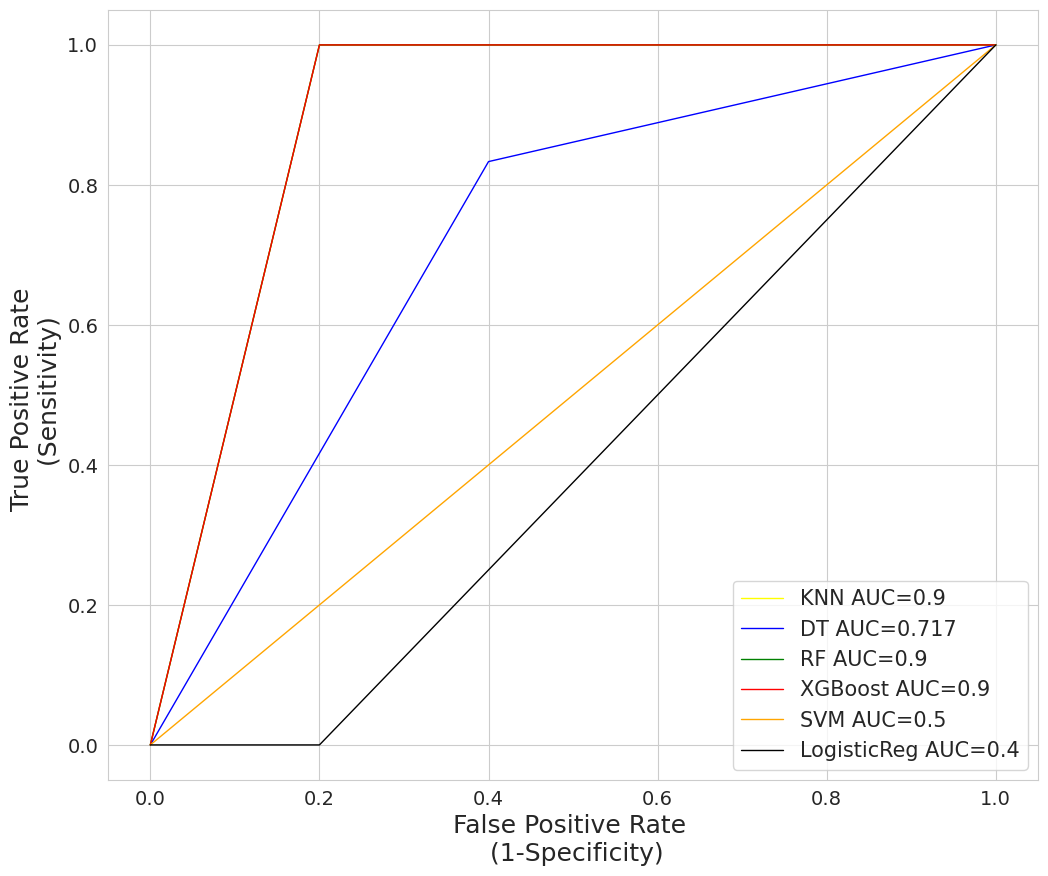

In [112]:

# Different Algorithms with the best parameters
KNN = KNeighborsClassifier(leaf_size= 1, metric= 'manhattan', n_neighbors= 5, weights= 'distance')
DT= DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf=3, min_samples_split=2, random_state=2023)
rf_clf1 = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, random_state=2023)
XGBoost = xgb.XGBClassifier(learning_rate= 1, max_depth= 3, min_child_weight= 0.5, n_estimators= 100, random_state=2023)
SVM = SVC(C= 0.0001, gamma=0.1, kernel= 'rbf', random_state=2023)
Logistic = LogisticRegression(C= 0.1, l1_ratio= 0.5, penalty= 'elasticnet', solver= 'saga', random_state=2023)

# model fit on train data
KNN.fit(X_train_uncorr, np.ravel(y_train))
DT.fit(X_train_uncorr, y_train)
rf_clf1.fit(X_train_uncorr, np.ravel(y_train))
XGBoost.fit(X_train_uncorr, np.ravel(y_train) )
SVM.fit(X_train_uncorr, np.ravel(y_train))
Logistic.fit(X_train_Dup, np.ravel(y_train))

# prediction of the model
pred_KNN = KNN.predict(X_test_uncorr)
pred_dt = DT.predict(X_test_uncorr)
pred_RF = rf_clf1.predict(X_test_uncorr)
pred_XGBoost = XGBoost.predict(X_test_uncorr)
pred_svm = SVM.predict(X_test_uncorr)
pred_Logistic = Logistic.predict(X_test_Dup)

# calculate roc auc for each model
AUC0 = roc_auc_score(y_test, pred_KNN)
AUC1 = roc_auc_score(y_test, pred_dt)
AUC2 = roc_auc_score(y_test, pred_RF)
AUC3 = roc_auc_score(y_test, pred_XGBoost)
AUC4 = roc_auc_score(y_test, pred_svm)
AUC5 = roc_auc_score(y_test, pred_Logistic)

print(f'ROC_AUC for KNN algorithm: {round(AUC0,3)}')
print(f'ROC_AUC for DT algorithm: {round(AUC1,3)}')
print(f'ROC_AUC for RF algorithm: {round(AUC2,3)}')
print(f'ROC_AUC for XGBoost algorithm: {round(AUC3,3)}')
print(f'ROC_AUC for SVM algorithm: {round(AUC4,3)}')
print(f'ROC_AUC for LogisticR algorithm: {round(AUC5,3)}')


# get false and true predictions for each model

fpr0, tpr0, thresholds0 = roc_curve(y_test, pred_KNN)
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_dt)
fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_RF)
fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_XGBoost)
fpr4, tpr4, thresholds4 = roc_curve(y_test, pred_svm)
fpr5, tpr5, thresholds5 = roc_curve(y_test, pred_Logistic)

# plot roc auc with calculated AUC values
plt.figure(figsize=(12, 10))
plt.plot(fpr0,tpr0, color='yellow', label="KNN AUC="+str(round(AUC0, 3)), lw=1)
plt.plot(fpr1,tpr1, color='blue', label="DT AUC="+str(round(AUC1, 3)), lw=1)
plt.plot(fpr2,tpr2, color='green', label="RF AUC="+str(round(AUC2, 3)), lw=1)
plt.plot(fpr3,tpr3, color='red', label="XGBoost AUC="+str(round(AUC3, 3)), lw=1)
plt.plot(fpr4,tpr4, color='orange', label="SVM AUC="+str(round(AUC4, 3)), lw=1)
plt.plot(fpr5,tpr5, color='black', label="LogisticReg AUC="+str(round(AUC5, 3)), lw=1)
plt.xlabel("False Positive Rate \n (1-Specificity)", fontsize= 18)
plt.ylabel("True Positive Rate \n (Sensitivity)", fontsize= 18)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=4, prop={'size': 15})

plt.savefig('/home/phoebe/phd/AUC_curves.pdf', dpi=800)

KNN: 0.450000 (0.415331)
DT: 0.500000 (0.433013)
RF: 0.600000 (0.374166)
XGB: 0.550000 (0.415331)
SVM: 0.800000 (0.331662)


/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoe

Logistic1: 0.475000 (0.261008)


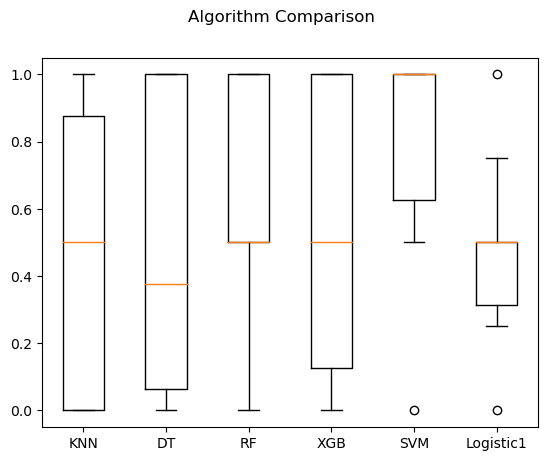

<Figure size 640x480 with 0 Axes>

In [106]:
# Models with best tuned hyperparameters:

KNN = KNeighborsClassifier(leaf_size= 1, metric= 'manhattan', n_neighbors= 5, weights= 'distance')
DT= DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf=3, min_samples_split=2, random_state=2023)
RF = RandomForestClassifier(criterion='gini', max_depth=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, random_state=2023)
XGBoost = xgb.XGBClassifier(learning_rate= 1, max_depth= 3, min_child_weight= 0.5, n_estimators= 100, random_state=2023)
SVM = SVC(C= 0.0001, gamma=0.1, kernel= 'rbf', random_state=2023)
Logistic1 = LogisticRegression(C= 0.1, l1_ratio= 0.5, penalty= 'elasticnet', solver= 'saga', random_state=2023)
#Logistic2 = LogisticRegression(C= 1, penalty= 'l1', solver= 'liblinear', random_state=2023)

# prepare configuration for cross validation test 
seed = 2023
# prepare models
models = []
models.append(('KNN', KNN))
models.append(('DT', DT))
models.append(('RF', RF))
models.append(('XGB', XGBoost))
models.append(('SVM', SVM))
models.append(('Logistic1', Logistic1))
# models.append(('Logistic2', Logistic2))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train_uncorr, np.ravel(y_train), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

plt.savefig('/home/phoebe/phd/Box_Plots', dpi=400)

In [107]:
pd.DataFrame(results, index=names)

,0,1,2,3,4,5,6,7,8,9
KNN,0.00,0.50,1.0,0.5,1.00,0.50,0.0,1.00,0.0,0.0
DT,0.00,0.25,1.0,1.0,0.00,0.25,1.0,1.00,0.0,0.5
RF,0.00,0.50,0.5,0.5,0.50,1.00,1.0,1.00,0.0,1.0
XGB,1.00,0.50,0.5,1.0,0.00,0.00,0.0,1.00,0.5,1.0
SVM,0.00,1.00,1.0,1.0,1.00,0.50,1.0,1.00,0.5,1.0
Logistic1,0.25,0.50,0.5,0.5,0.25,0.50,0.5,0.75,0.0,1.0


In [108]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for name, alg in models:  
    
    predicted = alg.fit(X_train_uncorr, np.ravel(y_train)).predict(X_test_uncorr)
    CM = confusion_matrix(y_test,predicted)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TNR = TN/(TN+FP)
    fnr = FN/(FN+TP)
    fpr = FP/(TN+FP)
  
    
    MLA_name = name
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train_uncorr, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test_uncorr, y_test), 4)
    MLA_compare.loc[row_index, 'Test ROC-AUC'] = roc_auc_score(y_test, predicted)
    MLA_compare.loc[row_index, 'Test Precission'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'Test Recall'] = recall_score(y_test, predicted)
    MLA_compare.loc[row_index, 'Test Specificity'] = round(TNR,3)


    row_index+=1

    
    
Logistic = LogisticRegression(C= 0.1, l1_ratio= 0.5, penalty= 'elasticnet', solver= 'saga', random_state=2023)
Logistic.fit(X_train_Dup, np.ravel(y_train))
pred_Logistic = Logistic.predict(X_test_Dup)
CM = confusion_matrix(y_test,pred_Logistic)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TNR = TN/(TN+FP)
fnr = FN/(FN+TP)
fpr = FP/(TN+FP)
MLA_compare.loc[row_index,'MLA used'] = 'LR'
MLA_compare.loc[row_index, 'Train Accuracy'] = round(Logistic.score(X_train_Dup, y_train), 4)
MLA_compare.loc[row_index, 'Test Accuracy'] = round(Logistic.score(X_test_Dup, y_test), 4)
MLA_compare.loc[row_index, 'Test ROC-AUC'] = roc_auc_score(y_test, pred_Logistic)
MLA_compare.loc[row_index, 'Test Precission'] = precision_score(y_test, pred_Logistic)
MLA_compare.loc[row_index, 'Test Recall'] = recall_score(y_test, pred_Logistic)
MLA_compare.loc[row_index, 'Test Specificity'] = round(TNR,3)
    
    
    
#MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/phoebe/miniconda3/envs/PJhm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,MLA used,Train Accuracy,Test Accuracy,Test ROC-AUC,Test Precission,Test Recall,Test Specificity
0,KNN,0.9333,0.9091,0.900000,0.857143,1.000000,0.8
1,DT,0.8667,0.7273,0.716667,0.714286,0.833333,0.6
2,RF,0.9333,0.9091,0.900000,0.857143,1.000000,0.8
3,XGB,0.9333,0.9091,0.900000,0.857143,1.000000,0.8
4,SVM,0.5333,0.5455,0.500000,0.545455,1.000000,0.0
5,Logistic1,0.6667,0.8182,0.800000,0.750000,1.000000,0.6
6,LR,0.6667,0.3636,0.400000,0.000000,0.000000,0.8


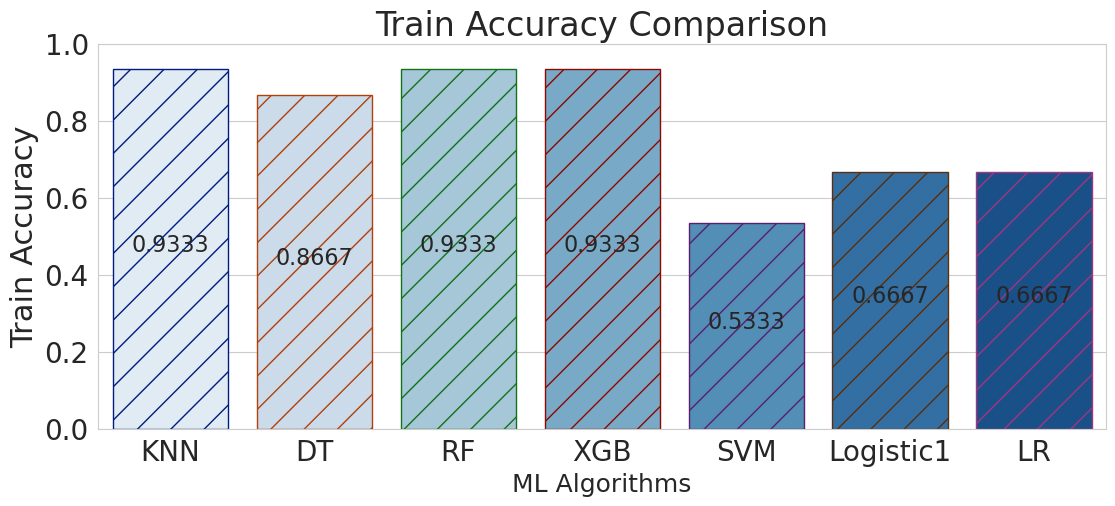

In [109]:
# Creating plot to show the train accuracy
plt.figure(figsize=(13,5))
sns.set_style('whitegrid')
ax =sns.barplot(x="MLA used", y="Train Accuracy",data=MLA_compare,palette='Blues',hatch='/' , edgecolor=sns.color_palette('dark',10), errorbar=('ci', 95))
ax.bar_label(ax.containers[0], padding=3, fontsize = 16, label_type='center')
plt.ylim([0,1.0])
plt.xlabel('ML Algorithms',fontsize=18)
plt.ylabel('Train Accuracy',fontsize=22)
plt.xticks(rotation= 0, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Train Accuracy Comparison', fontsize=24)


plt.savefig('/home/phoebe/phd/Train Accuracy.png', dpi=400)

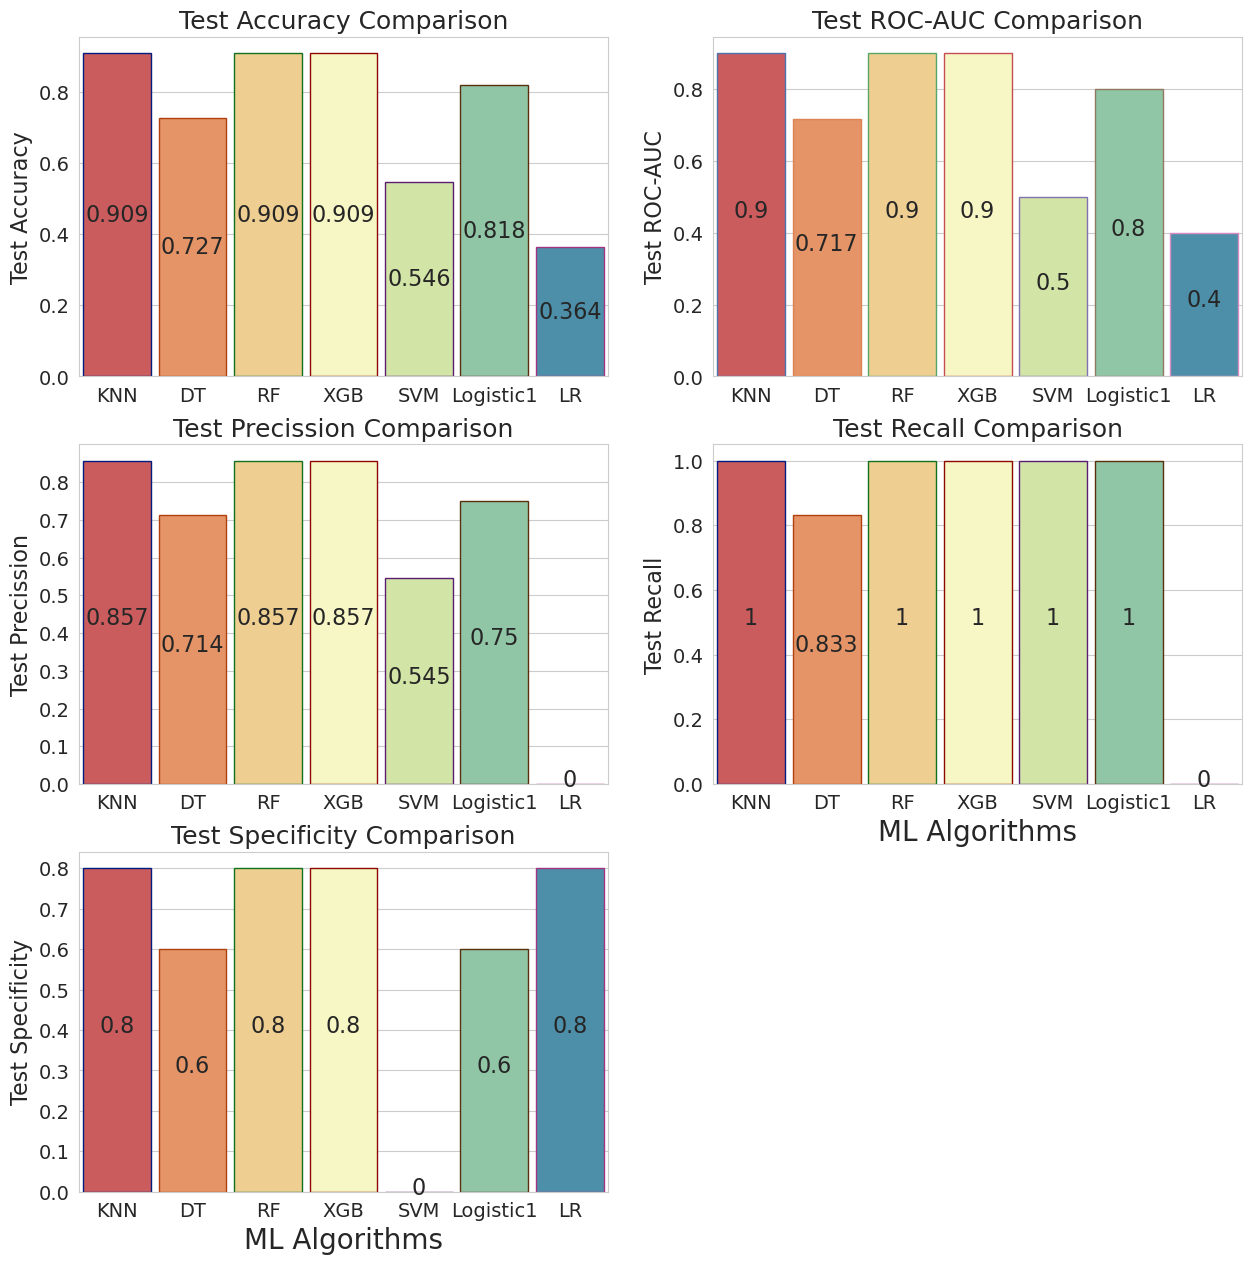

In [110]:
# Creating plot to show the test accuracy
plt.figure(figsize=(15,15))
plt.subplot(3, 2,1)
ax = sns.barplot(x="MLA used", y=round(MLA_compare['Test Accuracy'],3), data=MLA_compare, palette='Spectral',width=0.9,edgecolor=sns.color_palette('dark',7))
ax.bar_label(ax.containers[0], fontsize = 16, label_type='center')
plt.xlabel('')
plt.ylabel('Test Accuracy',fontsize=16)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Test Accuracy Comparison', fontsize=18)

plt.subplot(3, 2,2)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Test ROC-AUC"],3),data=MLA_compare,palette='Spectral', width=0.9,edgecolor=sns.color_palette('deep',7))
ax.bar_label(ax.containers[0], padding=3, fontsize = 16, label_type='center')
plt.xlabel('')
plt.ylabel('Test ROC-AUC',fontsize=16)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Test ROC-AUC Comparison', fontsize=18)

plt.subplot(3, 2,3)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Test Precission"],3),data=MLA_compare,palette='Spectral', width=0.9, edgecolor=sns.color_palette('dark',7))
ax.bar_label(ax.containers[0], padding=3, fontsize = 16, label_type='center')
plt.xlabel('')
plt.ylabel('Test Precission',fontsize=16)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Test Precission Comparison', fontsize=18)

plt.subplot(3, 2,4)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Test Recall"],3),data=MLA_compare,palette='Spectral', width=0.9, edgecolor=sns.color_palette('dark',7))
ax.bar_label(ax.containers[0], padding=3, fontsize = 16, label_type='center')
plt.xlabel('ML Algorithms',fontsize=20)
plt.ylabel('Test Recall',fontsize=16)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Test Recall Comparison', fontsize=18)

plt.subplot(3, 2,5)
ax = sns.barplot(x="MLA used", y=round(MLA_compare["Test Specificity"],3),data=MLA_compare,palette='Spectral', width=0.9, edgecolor=sns.color_palette('dark',7))
ax.bar_label(ax.containers[0], padding=3, fontsize = 16, label_type='center')
plt.xlabel('ML Algorithms',fontsize=20)
plt.ylabel('Test Specificity',fontsize=16)
plt.xticks(rotation= 0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Test Specificity Comparison', fontsize=18)




plt.savefig('/home/phoebe/phd/ALL_Test_metrics.pdf', dpi=800)